In [1]:
# Basic / Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams ['figure.figsize'] = 25, 10

%matplotlib inline

# Data transformation

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Clustering

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN


# ML toolkit

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost
import pickle
from sklearn.metrics import silhouette_score
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


import warnings
warnings.filterwarnings("ignore")



In [2]:
# Columns Names
names = ['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
         'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City',
         'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 
         'Sub_Category', 'Product_Name', 'Sales', 'Quantity', 'Discount', 
         'Profit']

df_raw = pd.read_excel('data/Sample - Superstore.xls',parse_dates = ['Order_Date','Ship_Date'], names= names) # read_csv


In [3]:
df_raw.Order_Date.max() # Max Date

Timestamp('2017-12-30 00:00:00')

In [4]:
df = df_raw.drop(['Row_ID', 'Order_ID', 'Customer_Name', 'Product_Name', 'Sales', 'Profit','Ship_Date'], axis=1) # Dropping values that are not going to be used for clustering/modeling

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 14 columns):
Order_Date      9994 non-null datetime64[ns]
Ship_Mode       9994 non-null object
Customer_ID     9994 non-null object
Segment         9994 non-null object
Country         9994 non-null object
City            9994 non-null object
State           9994 non-null object
Postal_Code     9994 non-null int64
Region          9994 non-null object
Product_ID      9994 non-null object
Category        9994 non-null object
Sub_Category    9994 non-null object
Quantity        9994 non-null int64
Discount        9994 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(10)
memory usage: 1.1+ MB


In [6]:
df.Postal_Code = df.Postal_Code.astype('object') # Casting Postal_Code as object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 14 columns):
Order_Date      9994 non-null datetime64[ns]
Ship_Mode       9994 non-null object
Customer_ID     9994 non-null object
Segment         9994 non-null object
Country         9994 non-null object
City            9994 non-null object
State           9994 non-null object
Postal_Code     9994 non-null object
Region          9994 non-null object
Product_ID      9994 non-null object
Category        9994 non-null object
Sub_Category    9994 non-null object
Quantity        9994 non-null int64
Discount        9994 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(11)
memory usage: 1.1+ MB


In [8]:
# Creating dataframe for quantity sum per shipping mode by product
sum_sales_shipmode = df[['Product_ID','Ship_Mode','Quantity']].groupby(['Product_ID','Ship_Mode']).sum()
sum_sales_shipmode.reset_index(inplace=True)
sum_sales_shipmode = sum_sales_shipmode.pivot(index='Product_ID',columns='Ship_Mode',values='Quantity')
sum_sales_shipmode.reset_index(inplace=True)
sum_sales_shipmode.head()

Ship_Mode       Product_ID  First Class  Same Day  Second Class  \
0          FUR-BO-10000112          9.0       NaN           NaN   
1          FUR-BO-10000330          2.0       4.0           NaN   
2          FUR-BO-10000362          3.0       1.0           NaN   
3          FUR-BO-10000468          NaN       NaN           8.0   
4          FUR-BO-10000711          NaN       NaN           NaN   

Ship_Mode  Standard Class  
0                     NaN  
1                     4.0  
2                    10.0  
3                    13.0  
4                    12.0

In [9]:
# Creating dataframe for unique customers by product
distinct_customers = df[['Product_ID','Customer_ID']].groupby('Product_ID')['Customer_ID'].unique()
distinct_customers = distinct_customers.reset_index()
distinct_customers['Customer_Distinct'] = distinct_customers.Customer_ID.apply(lambda x: len(x))
distinct_customers.drop('Customer_ID',axis=1,inplace=True)
distinct_customers.head()

Product_ID  Customer_Distinct
0  FUR-BO-10000112                  1
1  FUR-BO-10000330                  3
2  FUR-BO-10000362                  5
3  FUR-BO-10000468                  6
4  FUR-BO-10000711                  2

In [10]:
# Creating dataframe for quantity sum per segment by product
sum_sales_segment = df[['Product_ID','Segment','Quantity']].groupby(['Product_ID','Segment']).sum()
sum_sales_segment.reset_index(inplace=True)
sum_sales_segment = sum_sales_segment.pivot(index='Product_ID',columns='Segment',values='Quantity')
sum_sales_segment.reset_index(inplace=True)
sum_sales_segment.head()

Segment       Product_ID  Consumer  Corporate  Home Office
0        FUR-BO-10000112       NaN        9.0          NaN
1        FUR-BO-10000330       6.0        NaN          4.0
2        FUR-BO-10000362       1.0        8.0          5.0
3        FUR-BO-10000468      17.0        4.0          NaN
4        FUR-BO-10000711       9.0        NaN          3.0

In [11]:
# Creating dataframe quantity sum per state by product
sum_sales_state = df[['Product_ID','State','Quantity']].groupby(['Product_ID','State']).sum()
sum_sales_state.reset_index(inplace=True)
sum_sales_state = sum_sales_state.pivot(index='Product_ID',columns='State',values='Quantity')
sum_sales_state.reset_index(inplace=True)
sum_sales_state.head()

State       Product_ID  Alabama  Arizona  Arkansas  California  Colorado  \
0      FUR-BO-10000112      NaN      NaN       NaN         NaN       NaN   
1      FUR-BO-10000330      NaN      NaN       NaN         8.0       NaN   
2      FUR-BO-10000362      NaN      NaN       NaN         2.0       NaN   
3      FUR-BO-10000468      NaN      NaN       NaN         NaN       7.0   
4      FUR-BO-10000711      NaN      NaN       9.0         NaN       NaN   

State  Connecticut  Delaware  District of Columbia  Florida  ...  \
0              NaN       NaN                   NaN      NaN  ...   
1              NaN       NaN                   NaN      NaN  ...   
2              NaN       6.0                   NaN      NaN  ...   
3              NaN       NaN                   NaN      4.0  ...   
4              NaN       NaN                   NaN      NaN  ...   

State  South Dakota  Tennessee  Texas  Utah  Vermont  Virginia  Washington  \
0               NaN        NaN    NaN   NaN      NaN       NaN         NaN   
1               NaN        NaN    NaN   NaN      NaN       NaN         NaN   
2               NaN        NaN    NaN   NaN      NaN       NaN         NaN   
3               NaN        NaN    NaN   NaN      NaN       NaN         1.0   
4               NaN        NaN    NaN   NaN      NaN       NaN         NaN   

State  West Virginia  Wisconsin  Wyoming  
0                NaN        NaN      NaN  
1                NaN        NaN      NaN  
2                NaN        NaN      NaN  
3                NaN        NaN      NaN  
4                NaN        NaN      NaN  

[5 rows x 50 columns]

In [12]:
# Creating dataframe quantity sum per region by product
sum_sales_region = df[['Product_ID','Region','Quantity']].groupby(['Product_ID','Region']).sum()
sum_sales_region.reset_index(inplace=True)
sum_sales_region = sum_sales_region.pivot(index='Product_ID',columns='Region',values='Quantity')
sum_sales_region.reset_index(inplace=True)
sum_sales_region.head()

Region       Product_ID  Central  East  South  West
0       FUR-BO-10000112      9.0   NaN    NaN   NaN
1       FUR-BO-10000330      NaN   NaN    2.0   8.0
2       FUR-BO-10000362      3.0   9.0    NaN   2.0
3       FUR-BO-10000468      4.0   NaN    9.0   8.0
4       FUR-BO-10000711      3.0   NaN    9.0   NaN

In [13]:
# Creating dataframe average discount by product
avg_sales_disc = df[['Product_ID','Discount']].groupby(['Product_ID']).mean()
avg_sales_disc.reset_index(inplace=True)
avg_sales_disc.head()

Product_ID  Discount
0  FUR-BO-10000112  0.300000
1  FUR-BO-10000330  0.100000
2  FUR-BO-10000362  0.130000
3  FUR-BO-10000468  0.183333
4  FUR-BO-10000711  0.000000

In [14]:
# Get dummies for category and sub_category
df_agg = pd.DataFrame(df[['Product_ID','Category','Sub_Category']])
df_agg.set_index('Product_ID',inplace=True)
df_agg = pd.get_dummies(df_agg)
df_agg.reset_index(inplace=True)
df_agg.head()

Product_ID  Category_Furniture  Category_Office Supplies  \
0  FUR-BO-10001798                   1                         0   
1  FUR-CH-10000454                   1                         0   
2  OFF-LA-10000240                   0                         1   
3  FUR-TA-10000577                   1                         0   
4  OFF-ST-10000760                   0                         1   

   Category_Technology  Sub_Category_Accessories  Sub_Category_Appliances  \
0                    0                         0                        0   
1                    0                         0                        0   
2                    0                         0                        0   
3                    0                         0                        0   
4                    0                         0                        0   

   Sub_Category_Art  Sub_Category_Binders  Sub_Category_Bookcases  \
0                 0                     0                       1   
1                 0                     0                       0   
2                 0                     0                       0   
3                 0                     0                       0   
4                 0                     0                       0   

   Sub_Category_Chairs  ...  Sub_Category_Envelopes  Sub_Category_Fasteners  \
0                    0  ...                       0                       0   
1                    1  ...                       0                       0   
2                    0  ...                       0                       0   
3                    0  ...                       0                       0   
4                    0  ...                       0                       0   

   Sub_Category_Furnishings  Sub_Category_Labels  Sub_Category_Machines  \
0                         0                    0                      0   
1                         0                    0                      0   
2                         0                    1                      0   
3                         0                    0                      0   
4                         0                    0                      0   

   Sub_Category_Paper  Sub_Category_Phones  Sub_Category_Storage  \
0                   0                    0                     0   
1                   0                    0                     0   
2                   0                    0                     0   
3                   0                    0                     0   
4                   0                    0                     1   

   Sub_Category_Supplies  Sub_Category_Tables  
0                      0                    0  
1                      0                    0  
2                      0                    0  
3                      0                    1  
4                      0                    0  

[5 rows x 21 columns]

In [15]:
def multiple_merges(left,ls_dfs,how,on):
    # Function for merging several dataframes in a list
    for df_ in ls_dfs:
        left = left.merge(df_,how=how,on=on)
    return left


In [16]:
# Creating dataframe list
dfs_2_merge = [sum_sales_shipmode,distinct_customers,sum_sales_segment,sum_sales_state,sum_sales_region,avg_sales_disc]

In [17]:
# Setting all the merges to variable
df_agg = multiple_merges(left=df_agg,ls_dfs=dfs_2_merge,how='left',on='Product_ID')

In [18]:
# filling na values with 0
for column in df_agg.columns:
    df_agg[column] = df_agg[column].fillna(0)

In [19]:
df_agg.set_index('Product_ID',inplace=True)
df_agg.head()

Category_Furniture  Category_Office Supplies  \
Product_ID                                                      
FUR-BO-10001798                   1                         0   
FUR-CH-10000454                   1                         0   
OFF-LA-10000240                   0                         1   
FUR-TA-10000577                   1                         0   
OFF-ST-10000760                   0                         1   

                 Category_Technology  Sub_Category_Accessories  \
Product_ID                                                       
FUR-BO-10001798                    0                         0   
FUR-CH-10000454                    0                         0   
OFF-LA-10000240                    0                         0   
FUR-TA-10000577                    0                         0   
OFF-ST-10000760                    0                         0   

                 Sub_Category_Appliances  Sub_Category_Art  \
Product_ID                                                   
FUR-BO-10001798                        0                 0   
FUR-CH-10000454                        0                 0   
OFF-LA-10000240                        0                 0   
FUR-TA-10000577                        0                 0   
OFF-ST-10000760                        0                 0   

                 Sub_Category_Binders  Sub_Category_Bookcases  \
Product_ID                                                      
FUR-BO-10001798                     0                       1   
FUR-CH-10000454                     0                       0   
OFF-LA-10000240                     0                       0   
FUR-TA-10000577                     0                       0   
OFF-ST-10000760                     0                       0   

                 Sub_Category_Chairs  Sub_Category_Copiers  ...  Virginia  \
Product_ID                                                  ...             
FUR-BO-10001798                    0                     0  ...       0.0   
FUR-CH-10000454                    1                     0  ...       0.0   
OFF-LA-10000240                    0                     0  ...       0.0   
FUR-TA-10000577                    0                     0  ...       0.0   
OFF-ST-10000760                    0                     0  ...       0.0   

                 Washington  West Virginia  Wisconsin  Wyoming  Central  East  \
Product_ID                                                                      
FUR-BO-10001798         0.0            0.0        0.0      0.0      0.0   2.0   
FUR-CH-10000454         5.0            0.0        8.0      0.0     10.0  24.0   
OFF-LA-10000240         0.0            0.0        0.0      0.0      7.0   0.0   
FUR-TA-10000577         0.0            0.0        0.0      0.0      9.0   5.0   
OFF-ST-10000760         0.0            0.0        0.0      0.0      1.0   5.0   

                 South  West  Discount  
Product_ID                              
FUR-BO-10001798    5.0   5.0  0.212500  
FUR-CH-10000454    9.0   8.0  0.141667  
OFF-LA-10000240    4.0  12.0  0.085714  
FUR-TA-10000577    6.0   9.0  0.262500  
OFF-ST-10000760    2.0  16.0  0.120000  

[5 rows x 82 columns]

In [20]:
# Defining pipeline for standardscaler and minmaxscaler and then pca
steps_0 = [('scaler',StandardScaler()),('pca',PCA(n_components=3,random_state=42))]
steps_1 = [('scaler',MinMaxScaler()),('pca',PCA(n_components=3,random_state=42))]

pipeline_0 = Pipeline(steps_0)
pipeline_1 = Pipeline(steps_1)

In [21]:
# applying pipeline to variable
t_0 = pipeline_0.fit_transform(df_agg)
t_1 = pipeline_1.fit_transform(df_agg)
tf = [t_0,t_1]

1° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------


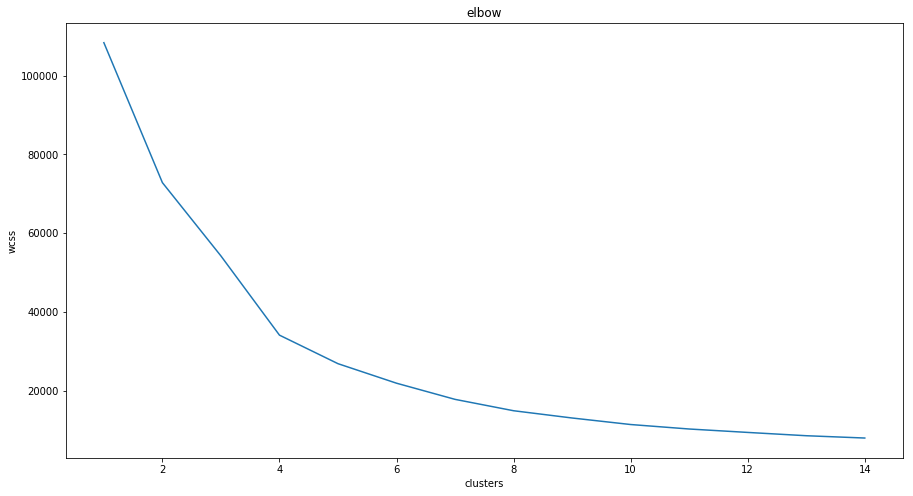

2° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------


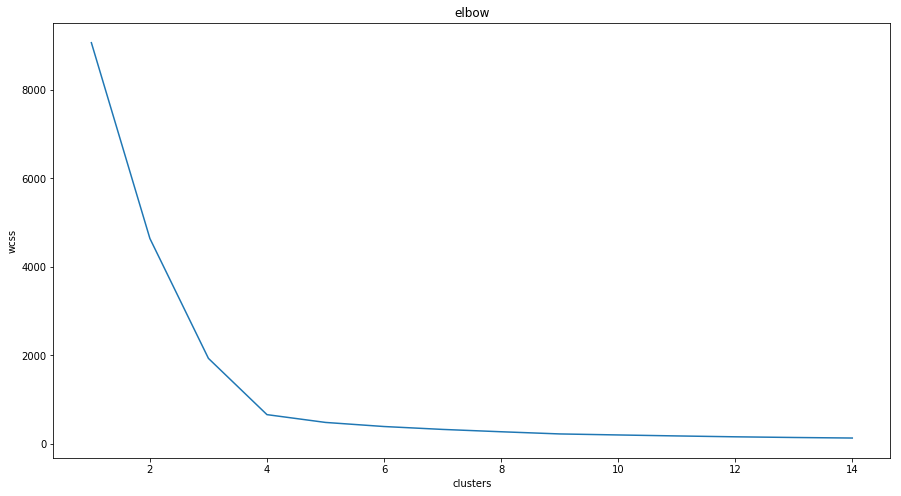

In [22]:
# plotting elbow method to determine optimal numbers of cluster
for index_tf, tf_ in enumerate(tf):
    print(f'{index_tf + 1}° iteração')
    print('-'*150)
    wcss = []
    for i in range(1,15):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(tf_)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(15,8))
    plt.plot(range(1,15),wcss)
    plt.title('elbow')
    plt.xlabel('clusters')
    plt.ylabel('wcss')
    plt.show()

1° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------


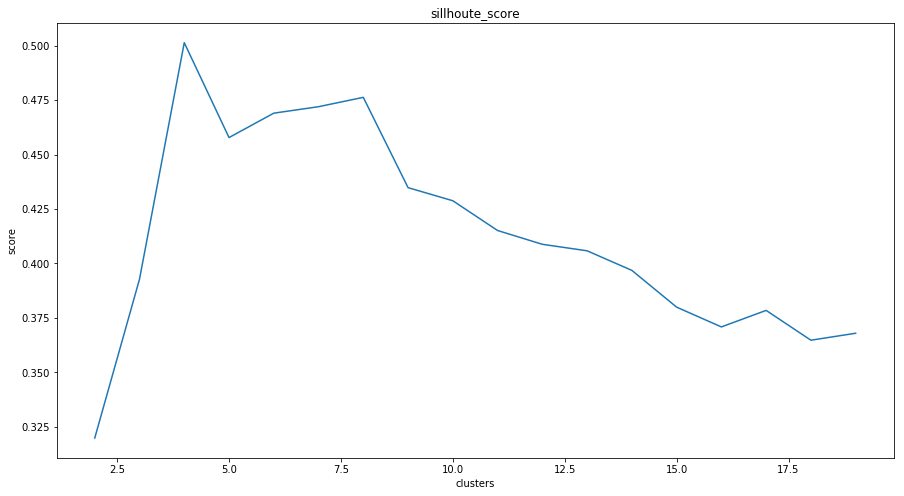

2° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------


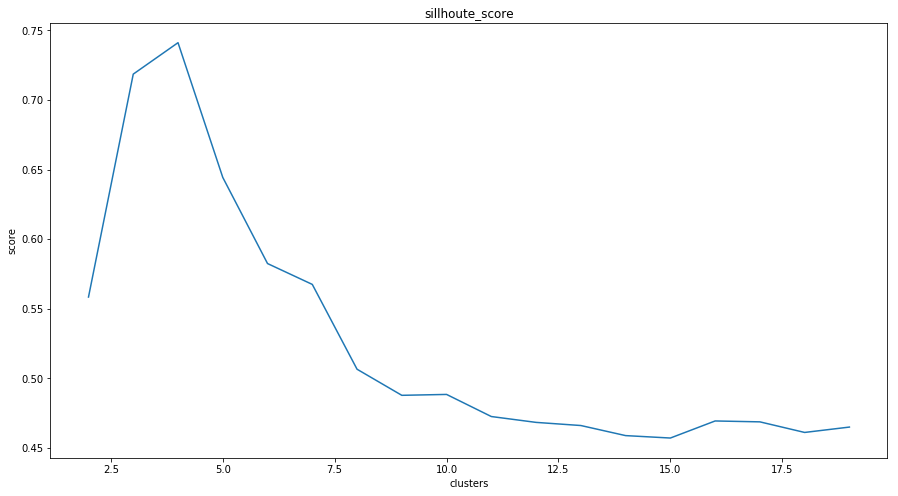

In [23]:
#silhoutte score to confirm number of clusters
for index_tf, tf_ in enumerate(tf):
    print(f'{index_tf + 1}° iteração')
    print('-'*150)
    sillhoute_scores = []
    for i in range(2,20):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(tf_)
        sillhoute_scores.append(silhouette_score(tf_, kmeans.labels_))

    plt.figure(figsize=(15,8))
    plt.plot(range(2,20),sillhoute_scores)
    plt.title('sillhoute_score')
    plt.xlabel('clusters')
    plt.ylabel('score')
    plt.show()

From the results above, we can try to fit a KMeans with 4 and 8 clusters.

1° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------
0.501376201711471


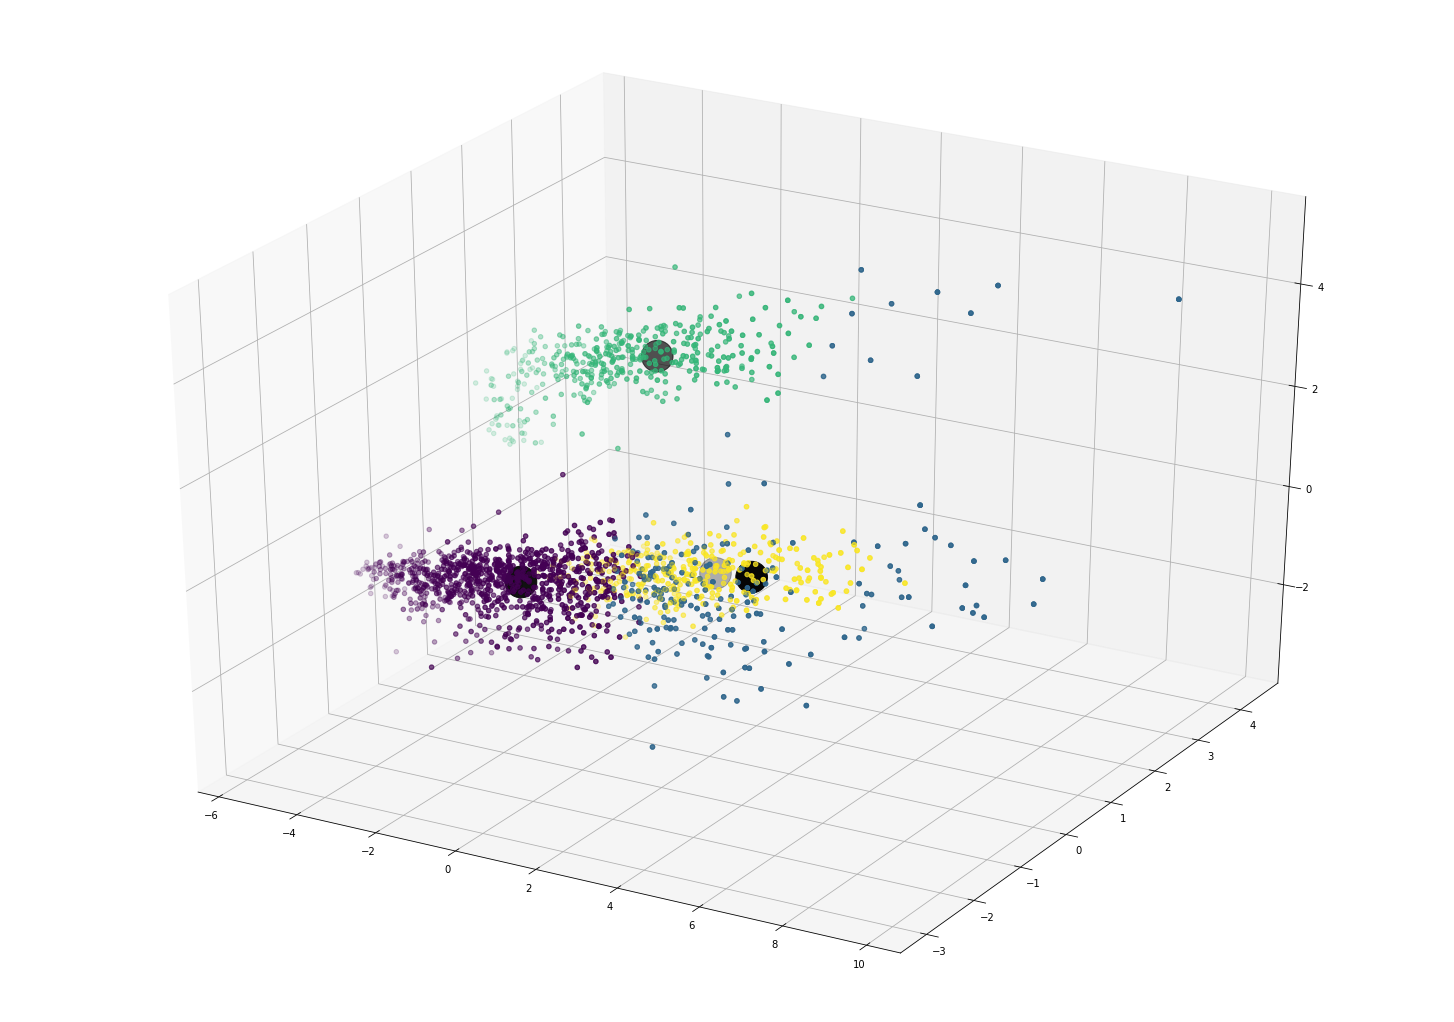

0.47605897472230235


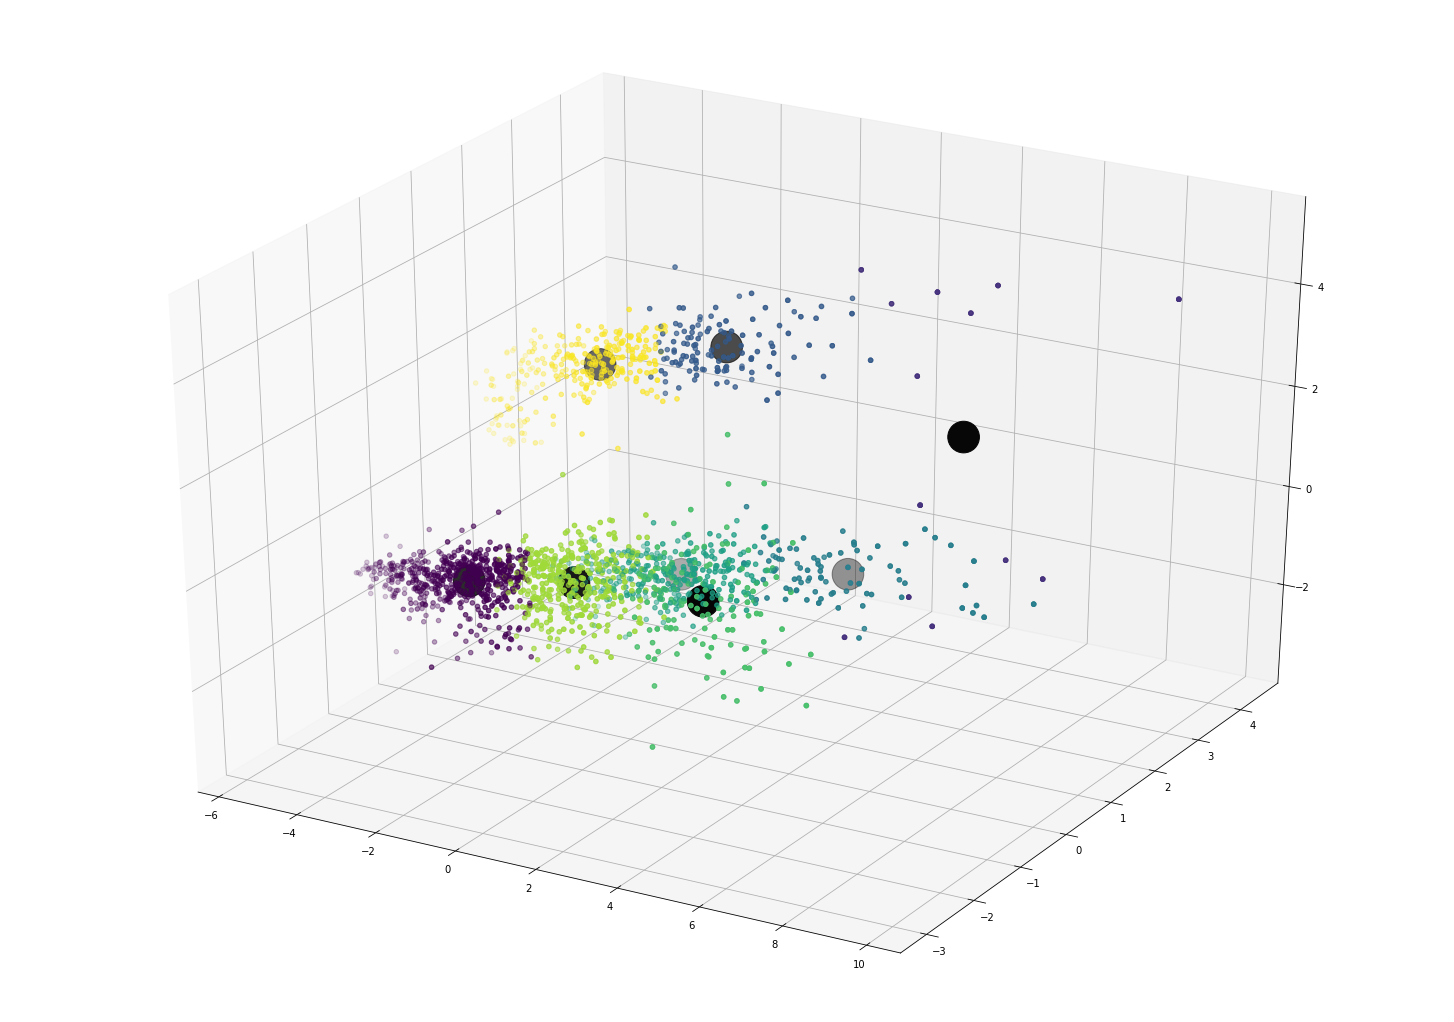

2° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------
0.7411500806482673


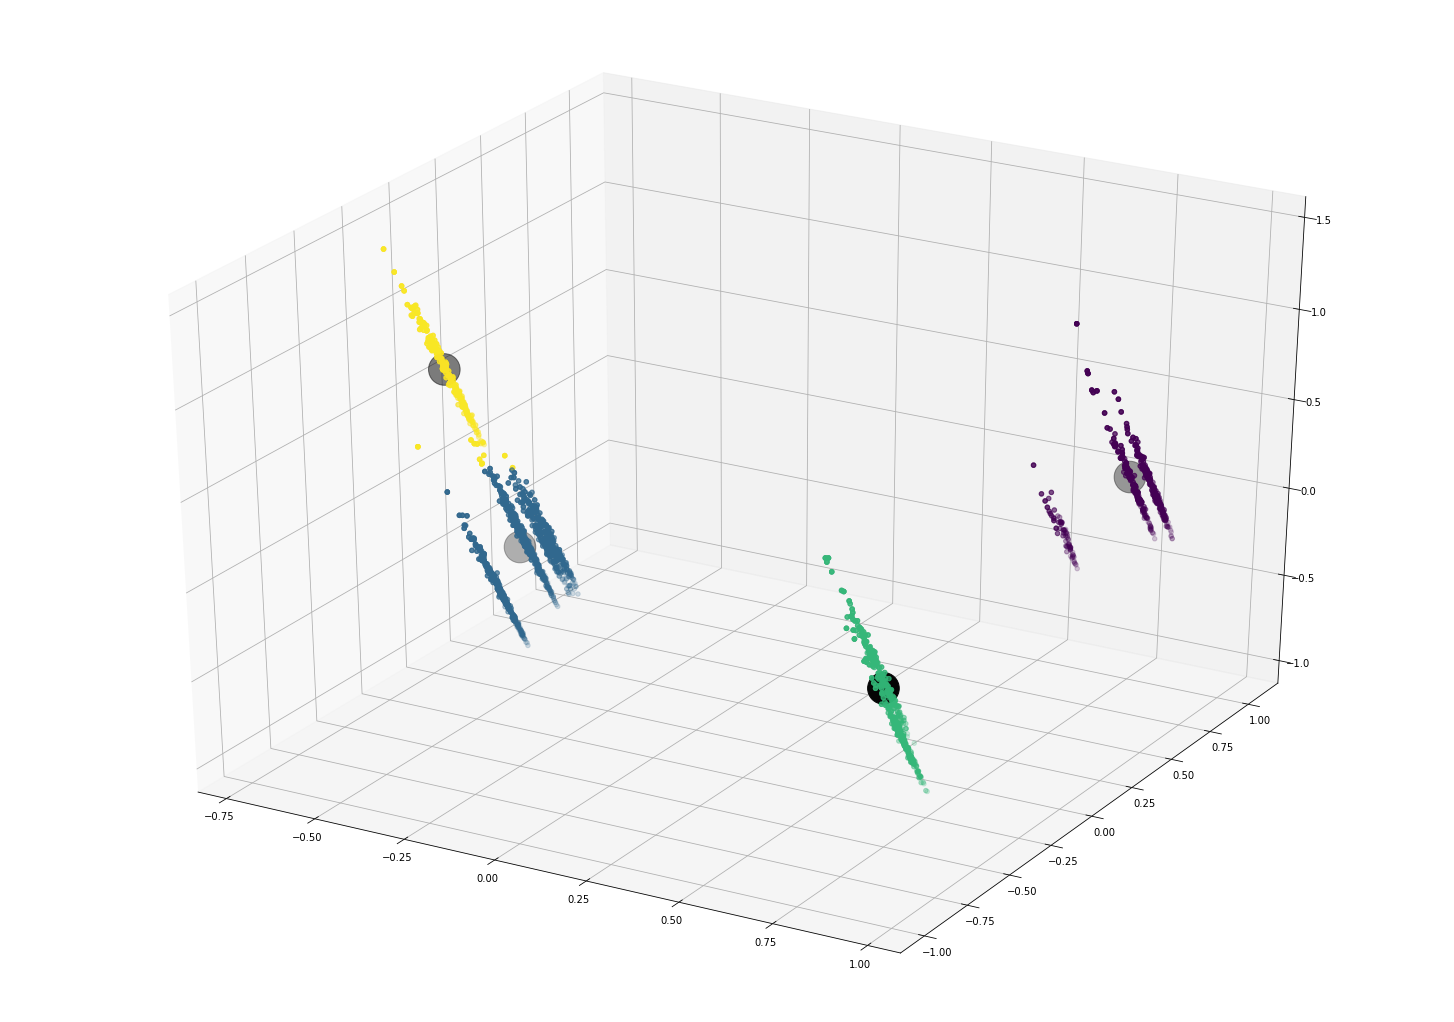

0.5059242593920575


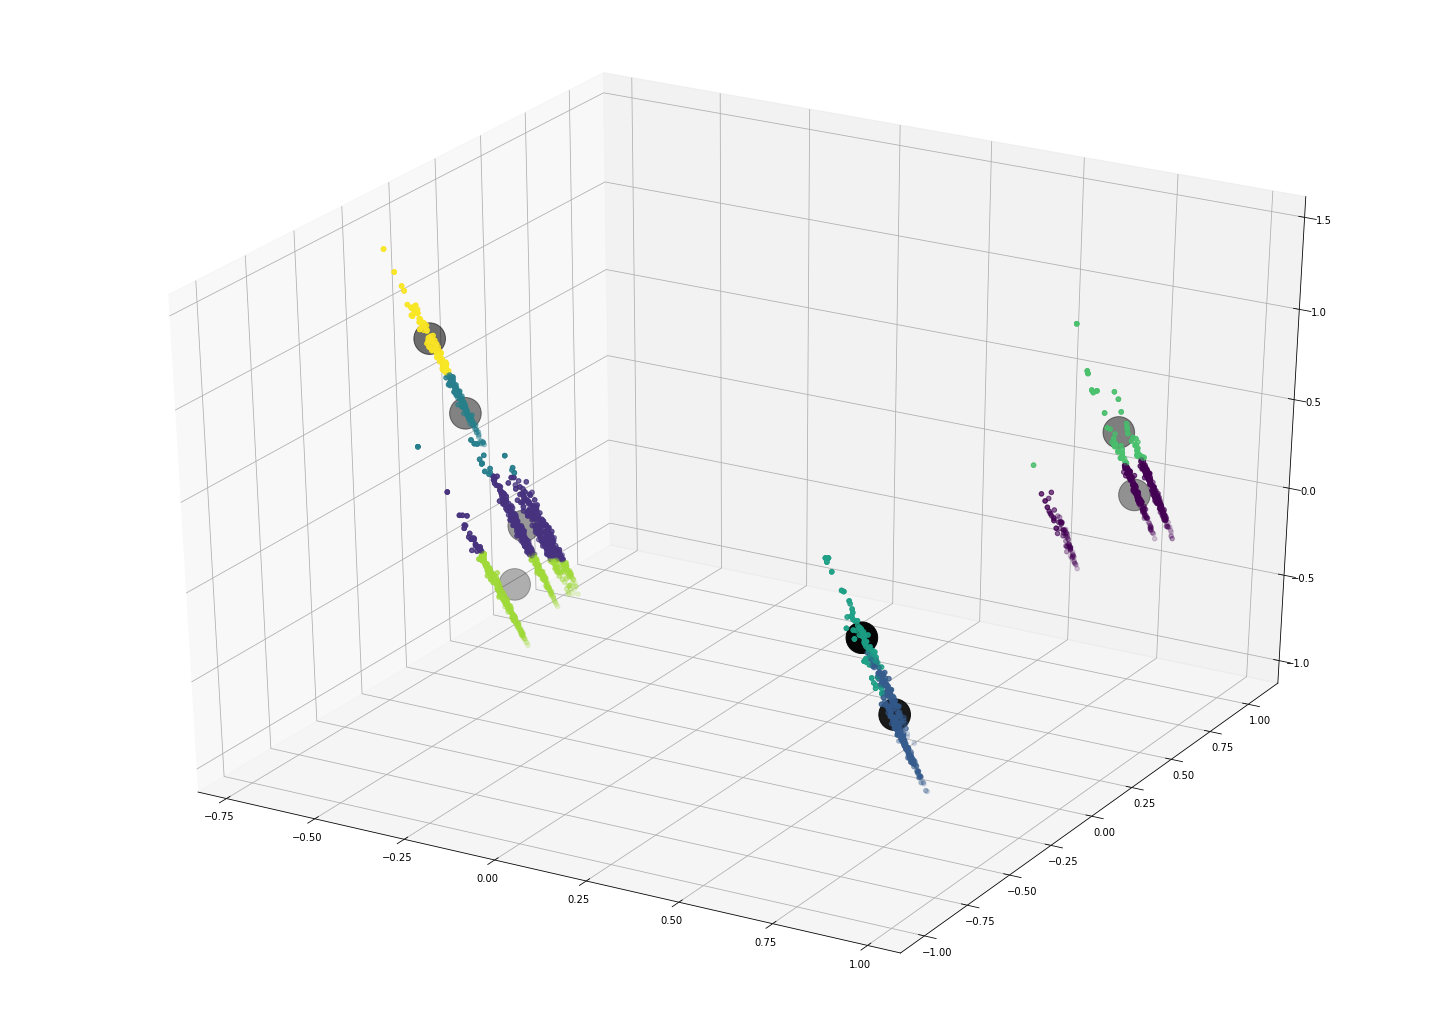

In [24]:
# Looking results for a KMeans with 4 and 8 clusters and for the 2 pipelines
for index_tf, tf_ in enumerate(tf):
    print(f'{index_tf + 1}° iteração')
    print('-'*150)
    for i in [4,8]:
        kmeans = KMeans(n_clusters= i)
        kmeans.fit(tf_)
        labels = kmeans.predict(tf_)
        C = kmeans.cluster_centers_
        print(silhouette_score(tf_,kmeans.labels_))
        fig = plt.figure(figsize=(20,14))
        ax = Axes3D(fig)
        ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='o', c='#050505', s=1000, zorder=100)
        ax.scatter(tf_[:, 0], tf_[:, 1], tf_[:, 2], zorder=0, alpha=0.2, c=labels)
        plt.show()

1° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------


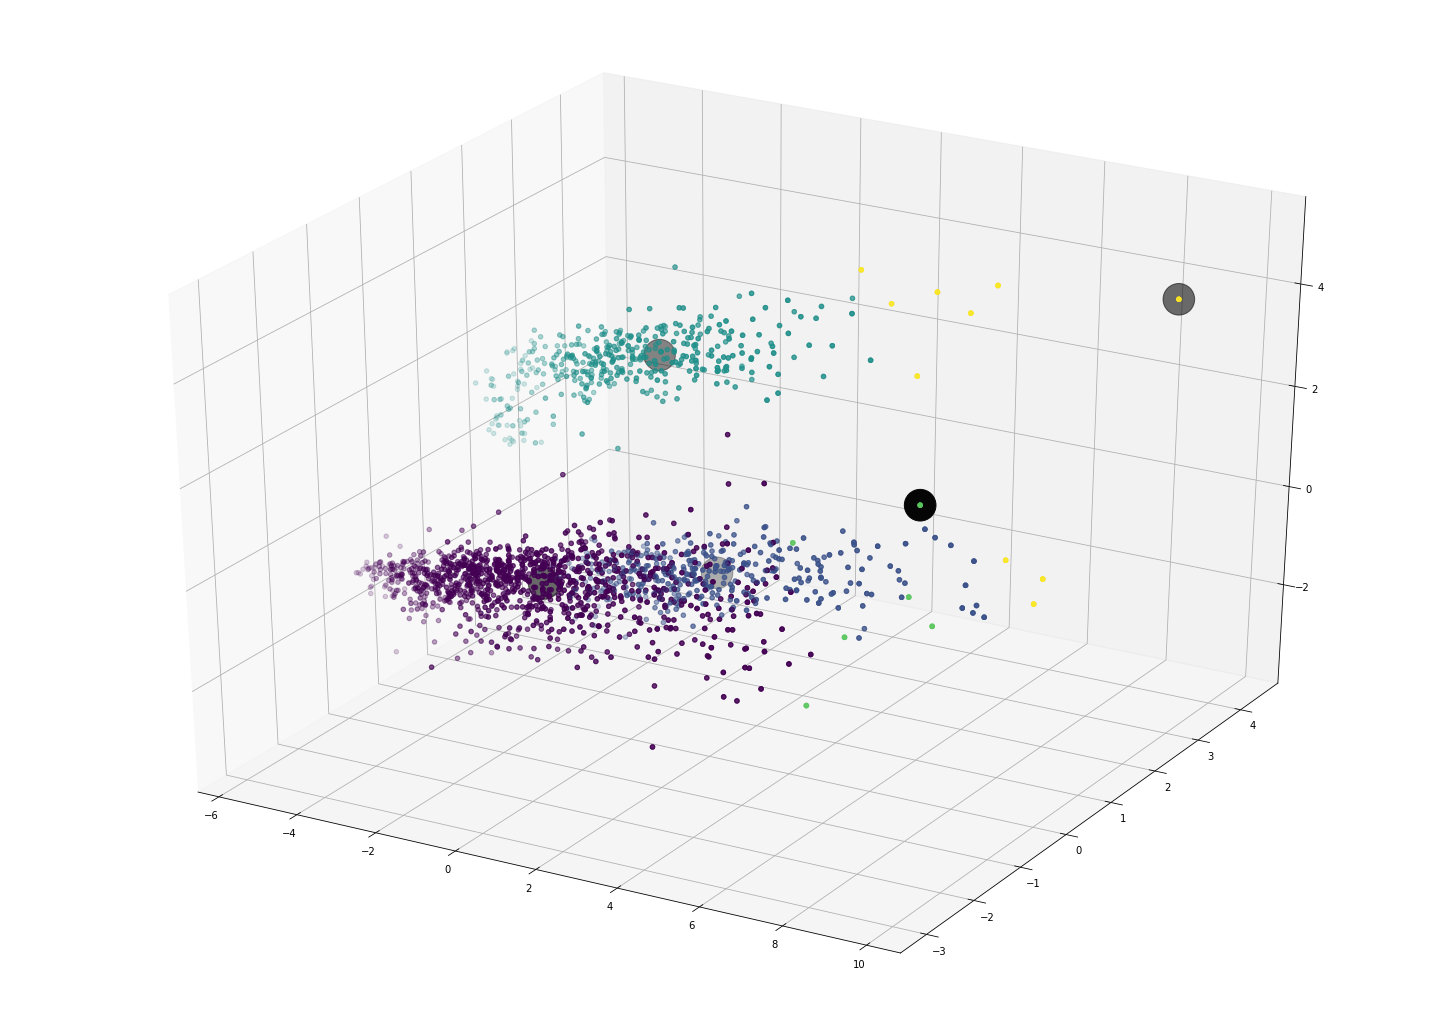

2° iteração
------------------------------------------------------------------------------------------------------------------------------------------------------


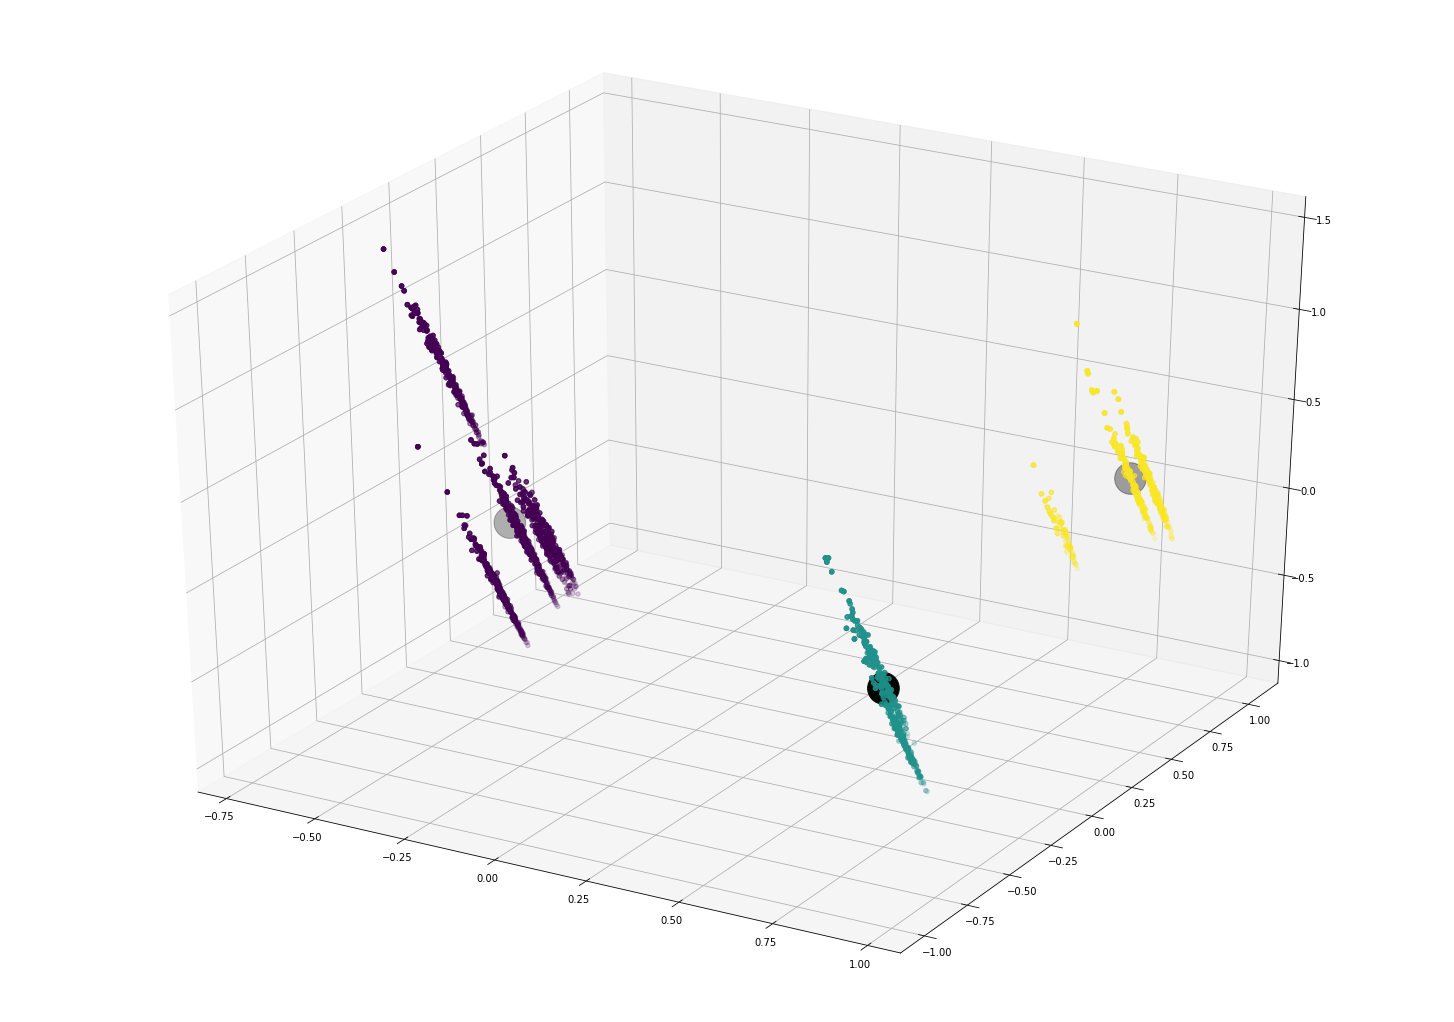

In [25]:
# Trying to fit a MeanShift to see results
ms = MeanShift()
for index_tf, tf_ in enumerate(tf):
    print(f'{index_tf + 1}° iteração')
    print('-'*150)
    ms.fit(tf_)
    labels = ms.predict(tf_)
    C = ms.cluster_centers_
    fig = plt.figure(figsize=(20,14))
    ax = Axes3D(fig)
    ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='o', c='#050505', s=1000, zorder=100)
    ax.scatter(tf_[:, 0], tf_[:, 1], tf_[:, 2], zorder=0, alpha=0.2, c=labels)
    plt.show()

In [26]:
# Apparently the 4 clusters KMeans had better results
kmeans = KMeans(n_clusters= 4)
kmeans.fit(t_1)
labels = pd.Series(kmeans.predict(t_1))
C = kmeans.cluster_centers_

In [27]:
labels = labels[:,np.newaxis]
labels = pd.DataFrame(labels, columns = ['Cluster'])
df_agg.reset_index(inplace=True)
df_agg = pd.concat([df_agg,labels],axis=1)

In [28]:
df_agg.Cluster.value_counts(dropna=False)

0    4381
2    2121
1    1847
3    1645
Name: Cluster, dtype: int64

In [29]:
# Creating a dataframe for cluster dimension (Product_ID - Cluster)
df_dim_cluster = df_agg[['Product_ID','Cluster']]

In [30]:
df_dim_cluster.head()

Product_ID  Cluster
0  FUR-BO-10001798        2
1  FUR-CH-10000454        2
2  OFF-LA-10000240        0
3  FUR-TA-10000577        2
4  OFF-ST-10000760        0

In [31]:
# Dropping duplicates
df_dim_cluster.drop_duplicates(inplace=True)

In [32]:
# Exporting to csv for later api uses
df_dim_cluster.to_csv('product_cluster.csv')

In [33]:
df_dim_cluster.Cluster.value_counts()

0    863
1    404
2    375
3    220
Name: Cluster, dtype: int64

In [34]:
# Dataframe base for all time series
df_ts_all = df.merge(df_dim_cluster,how='left',on='Product_ID')[['Order_Date','Product_ID','Quantity','Cluster']]

In [35]:
df_ts_all.head(10)

Order_Date       Product_ID  Quantity  Cluster
0 2016-11-08  FUR-BO-10001798         2        2
1 2016-11-08  FUR-CH-10000454         3        2
2 2016-06-12  OFF-LA-10000240         2        0
3 2015-10-11  FUR-TA-10000577         5        2
4 2015-10-11  OFF-ST-10000760         2        0
5 2014-06-09  FUR-FU-10001487         7        2
6 2014-06-09  OFF-AR-10002833         4        0
7 2014-06-09  TEC-PH-10002275         6        1
8 2014-06-09  OFF-BI-10003910         3        3
9 2014-06-09  OFF-AP-10002892         5        0

In [36]:
# Creating separate dataframes for each cluster
df_ts_0 = df_ts_all[df_ts_all['Cluster'] == 0][['Order_Date','Quantity']].groupby('Order_Date').sum()
df_ts_1 = df_ts_all[df_ts_all['Cluster'] == 1][['Order_Date','Quantity']].groupby('Order_Date').sum()
df_ts_2 = df_ts_all[df_ts_all['Cluster'] == 2][['Order_Date','Quantity']].groupby('Order_Date').sum()
df_ts_3 = df_ts_all[df_ts_all['Cluster'] == 3][['Order_Date','Quantity']].groupby('Order_Date').sum()


In [37]:
df_ts_0.reset_index(inplace=True)
df_ts_1.reset_index(inplace=True)
df_ts_2.reset_index(inplace=True)
df_ts_3.reset_index(inplace=True)

In [38]:
df_ts = [df_ts_0,df_ts_1,df_ts_2,df_ts_3]

Distribution for cluster: 0
------------------------------------------------------------------------------------------------------------------------------------------------------


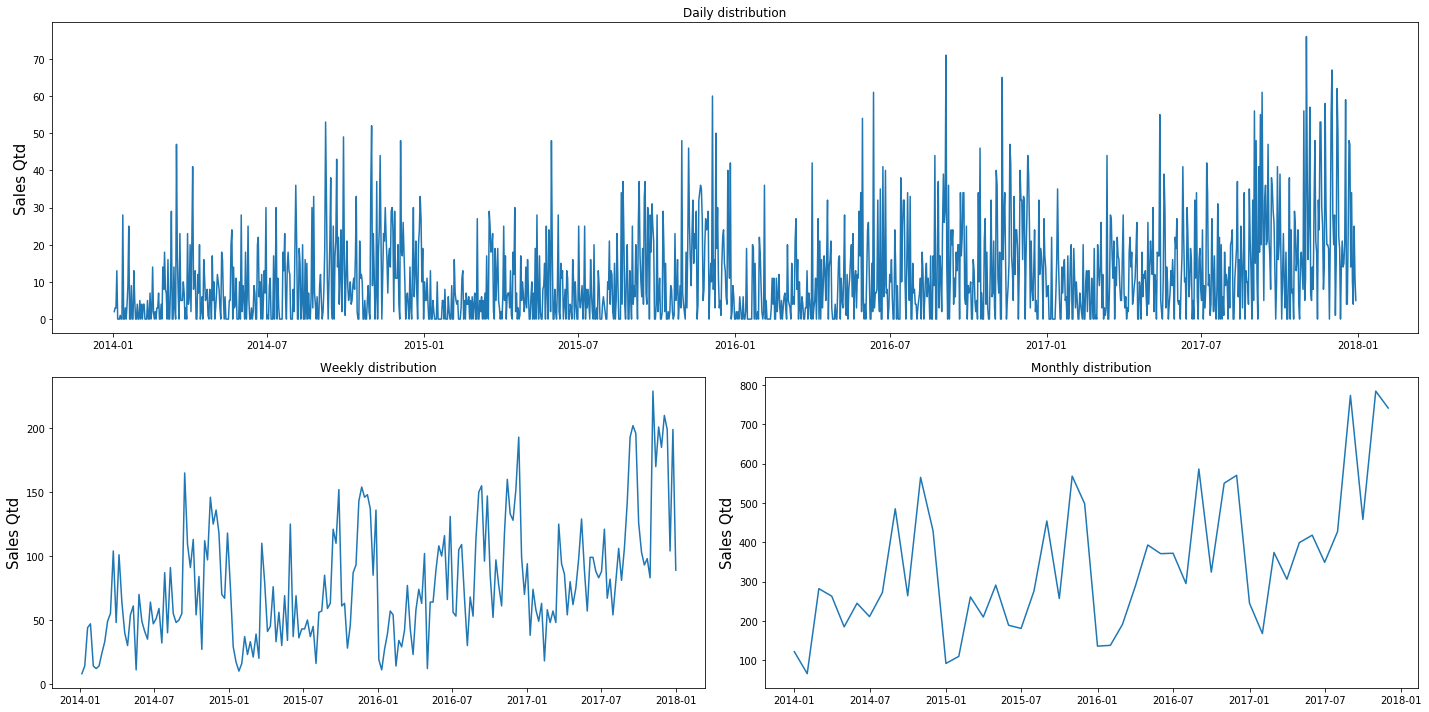

Distribution for cluster: 1
------------------------------------------------------------------------------------------------------------------------------------------------------


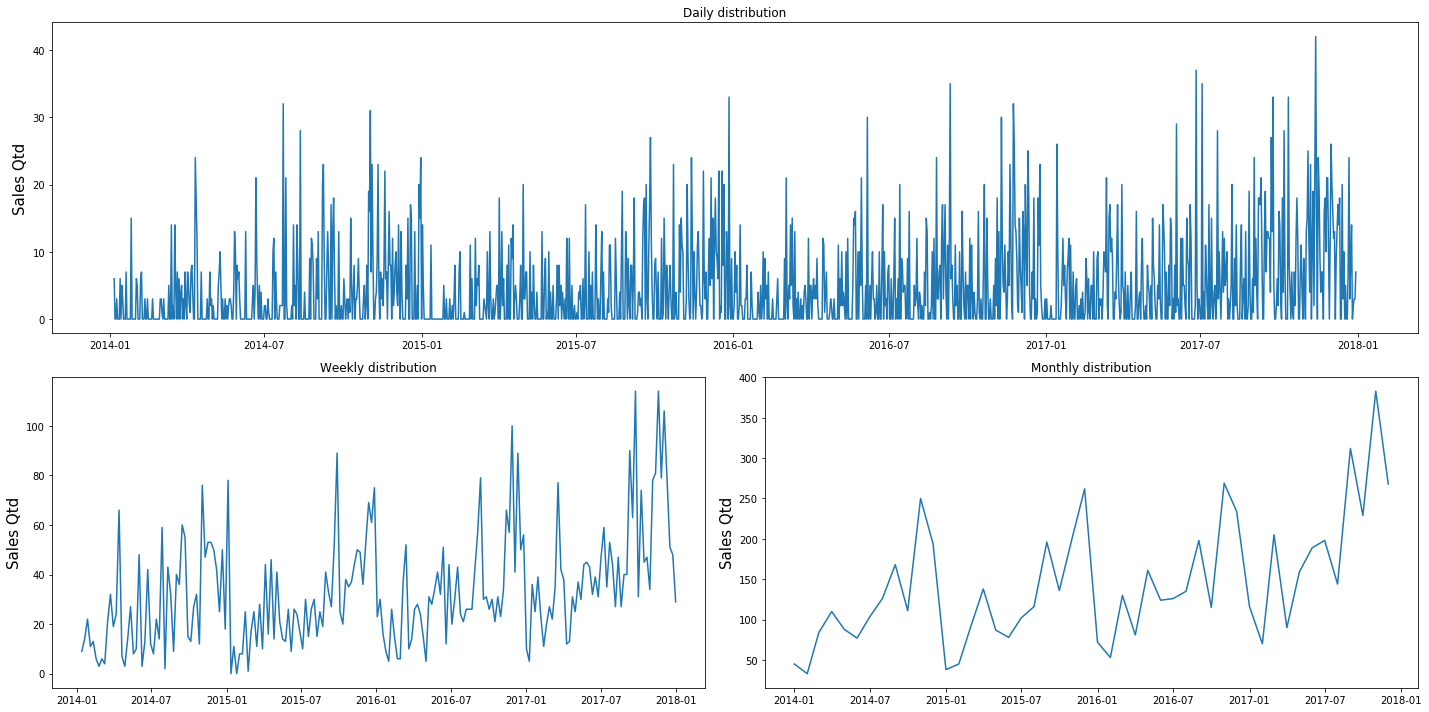

Distribution for cluster: 2
------------------------------------------------------------------------------------------------------------------------------------------------------


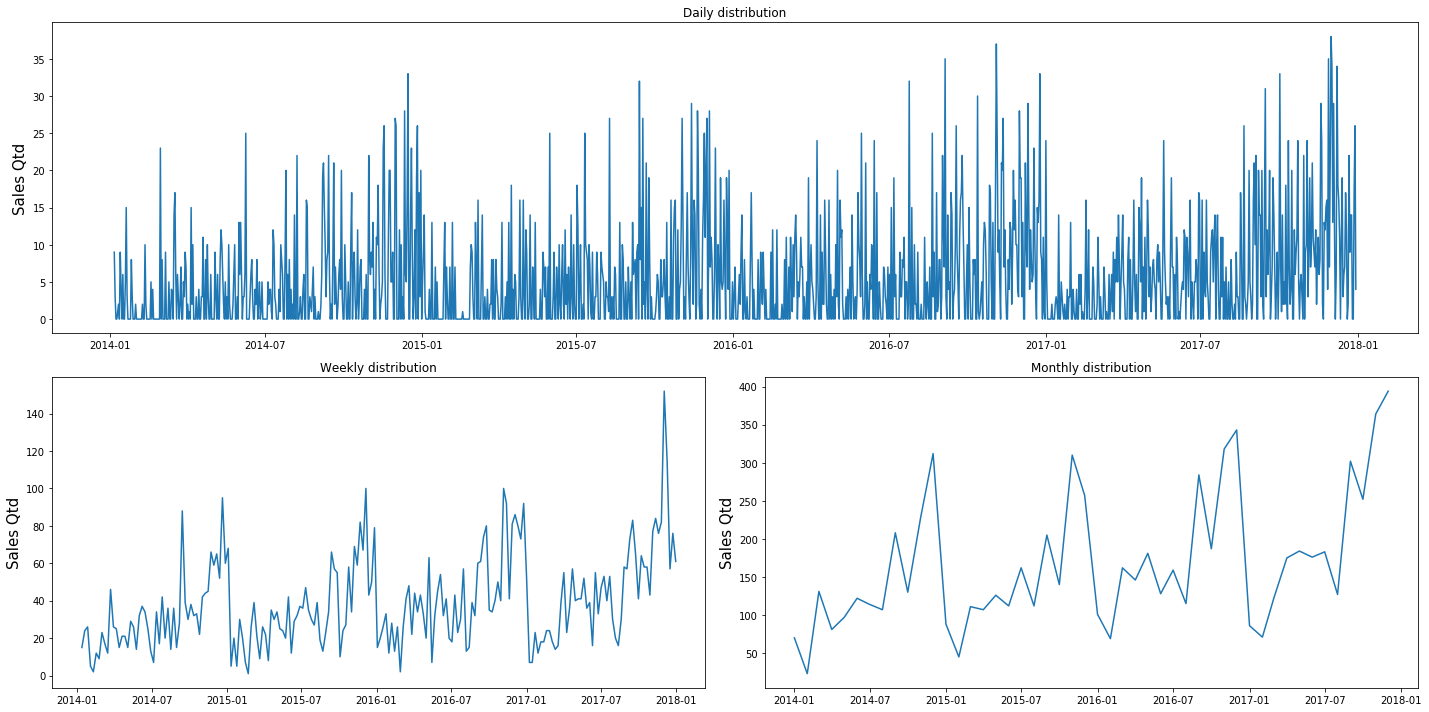

Distribution for cluster: 3
------------------------------------------------------------------------------------------------------------------------------------------------------


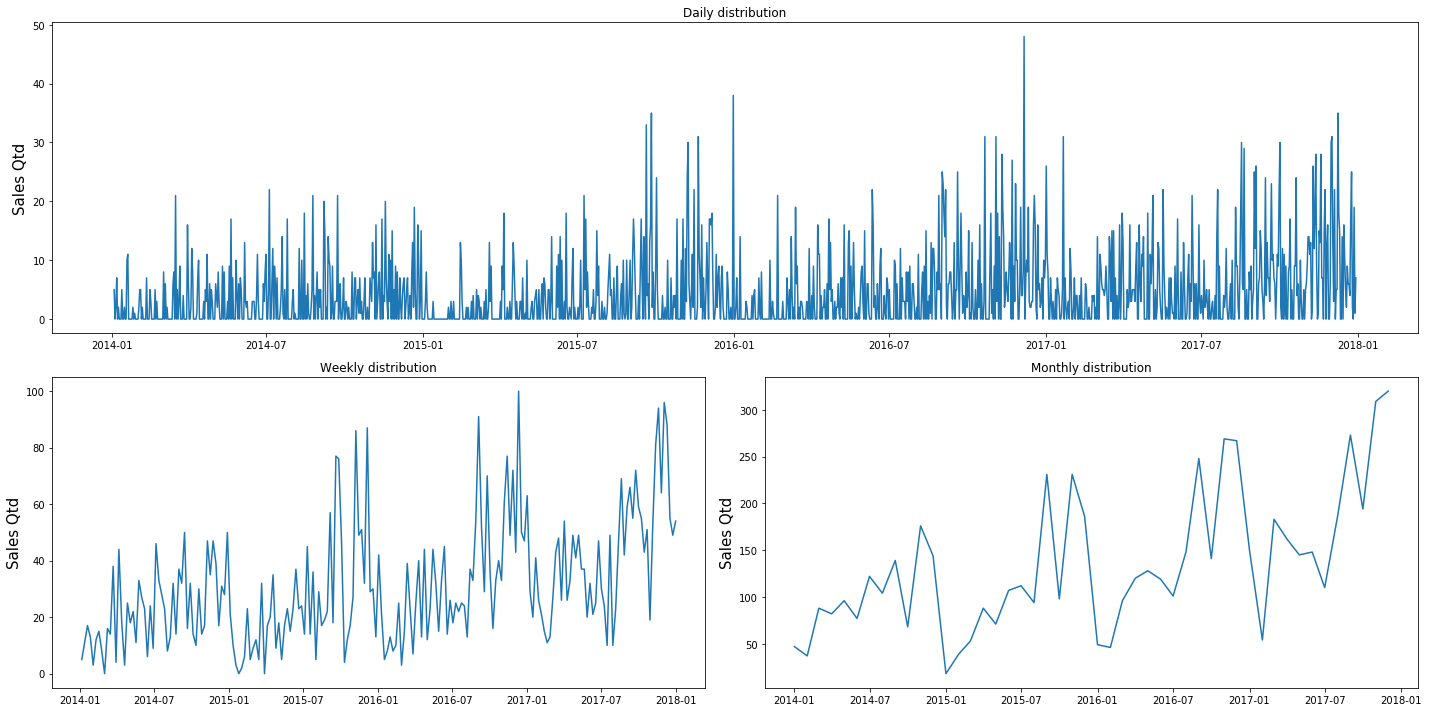

In [39]:
# Plotting daily, weekly and monthly distribution of sales for each cluster
for _, df in enumerate(df_ts):
    print(f'Distribution for cluster: {_}')
    print('-'*150)
#     df.reset_index(inplace=True)
    df.set_index('Order_Date',inplace=True)
    y0 = df['Quantity'].resample('D').sum()
    y1 = df['Quantity'].resample('W').sum()
    y2 = df['Quantity'].resample('MS').sum()
    plt.figure(figsize=(20,10))
    gridspec.GridSpec(4,4)
    plt.subplot(2,1,1)
    plt.title(f'Daily distribution')
    plt.ylabel('Sales Qtd', fontsize = 15) #for y label
    plt.plot(y0.index, y0.values)
    plt.subplot(2,2,3)
    plt.title(f'Weekly distribution')
    plt.ylabel('Sales Qtd', fontsize = 15) #for y label
    plt.plot(y1.index, y1.values)
    plt.subplot(2,2,4)
    plt.title(f'Monthly distribution')
    plt.ylabel('Sales Qtd', fontsize = 15) #for y label
    plt.plot(y2.index, y2.values)
    plt.tight_layout()
    plt.show()
    

Forecasting for cluster: 0
------------------------------------------------------------------------------------------------------------------------------------------------------


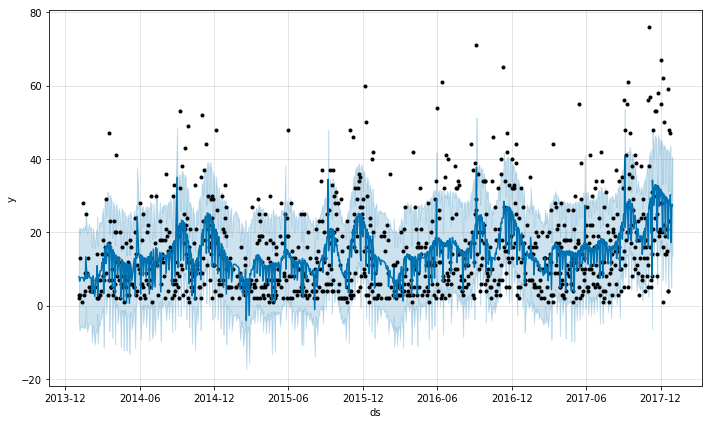

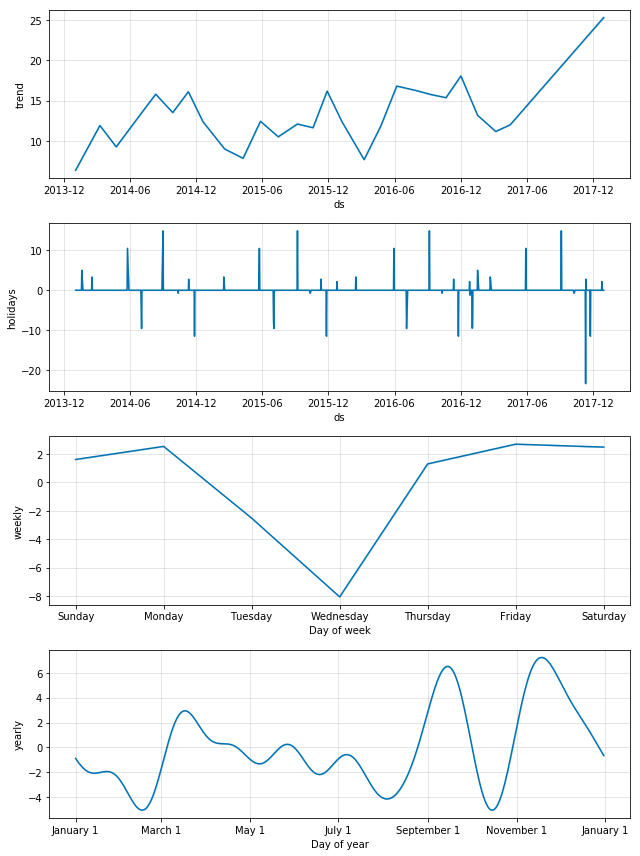

Forecasting for cluster: 1
------------------------------------------------------------------------------------------------------------------------------------------------------


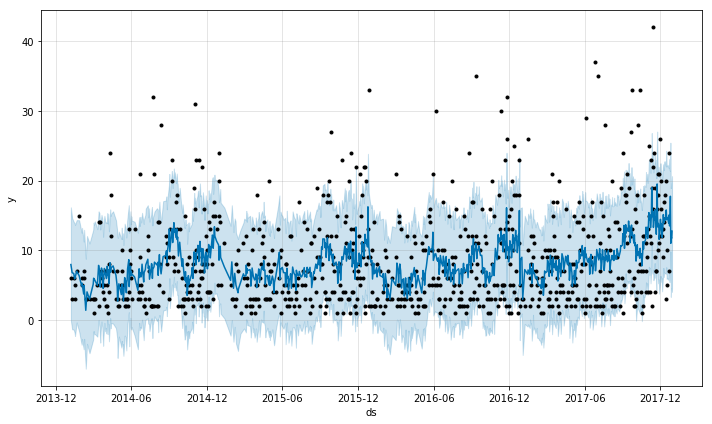

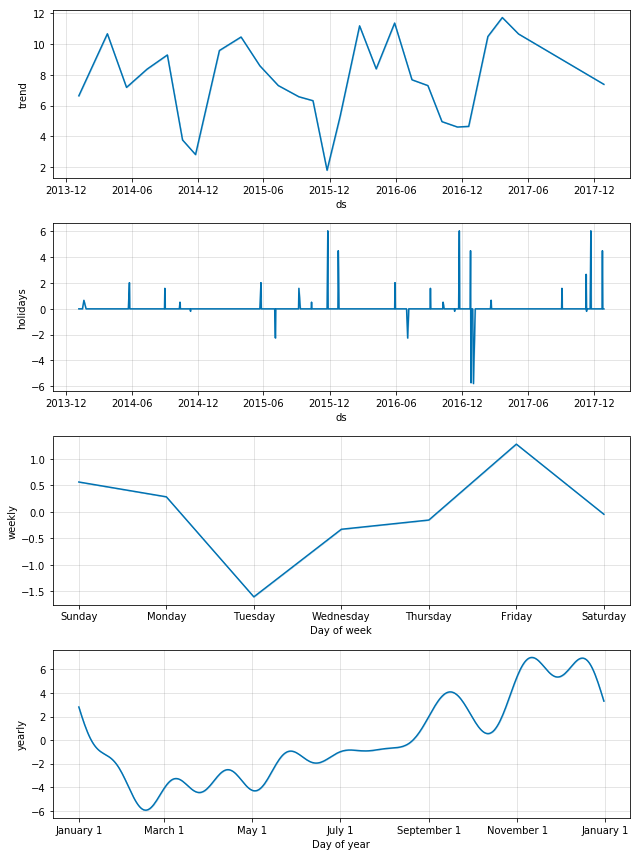

Forecasting for cluster: 2
------------------------------------------------------------------------------------------------------------------------------------------------------


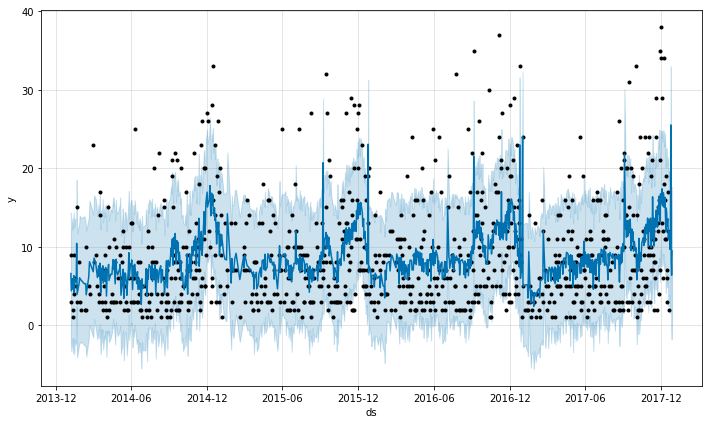

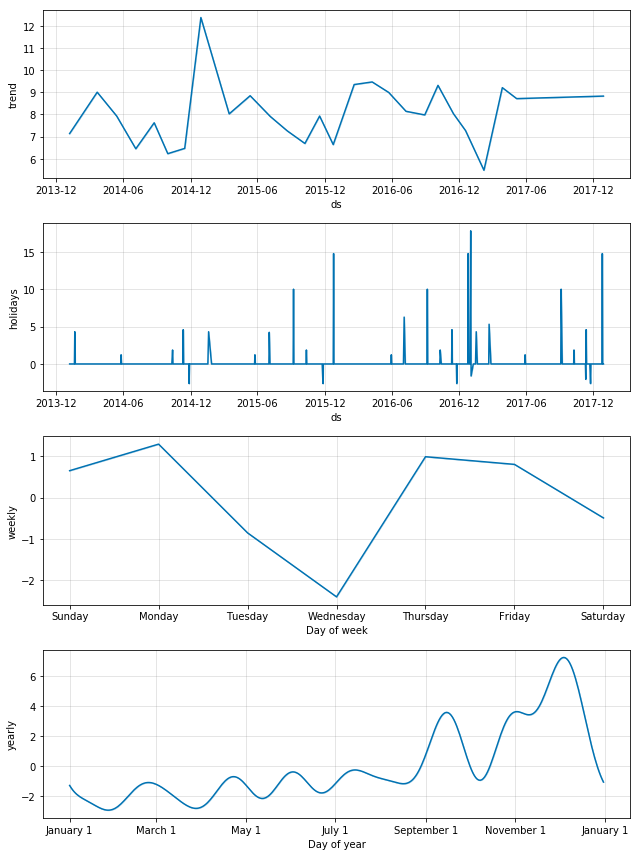

Forecasting for cluster: 3
------------------------------------------------------------------------------------------------------------------------------------------------------


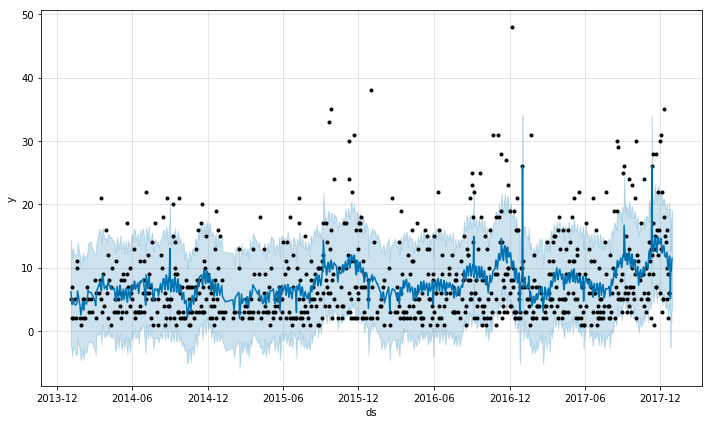

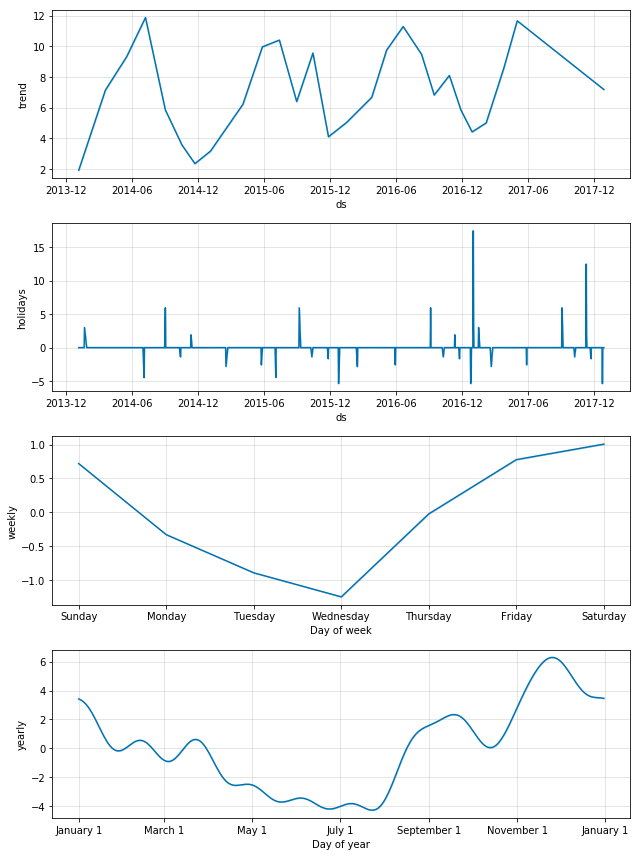

In [40]:
# Fitting fbprophet and plotting results in the daily distribution for each cluster
forecasts ={}
models_daily = {}
dict_predict_daily = {}
for _, df in enumerate(df_ts):
    print(f'Forecasting for cluster: {_}')
    print('-'*150)
    df.reset_index(inplace=True)
    df.columns = ['ds','y']
    prediction_size = 7
    train_df = df[:-prediction_size]
    model = Prophet(changepoint_prior_scale=50, daily_seasonality=False)
    model.add_country_holidays(country_name='US')
    model.fit(train_df)
    future_dates = model.make_future_dataframe(periods=prediction_size,freq='D')
    forecast = model.predict(future_dates)
    m_predict_daily = model.predict(df)
    model.plot(forecast,uncertainty=True)
    model.plot_components(forecast)
    forecasts['forecast' + str(_)] = forecast
    dict_predict_daily['prd_daily_' + str(_)] = m_predict_daily
    models_daily['ts' + str(_) + '_pkl_D'] = model
    plt.show()


In [41]:
models_daily

{'ts0_pkl_D': <fbprophet.forecaster.Prophet at 0x7fcc1452ab70>,
 'ts1_pkl_D': <fbprophet.forecaster.Prophet at 0x7fcc14557f98>,
 'ts2_pkl_D': <fbprophet.forecaster.Prophet at 0x7fcc17be6ef0>,
 'ts3_pkl_D': <fbprophet.forecaster.Prophet at 0x7fcc18070c88>}

In [42]:
# Deploying pkl models 
for name,model in models_daily.items():
    pickle.dump(model, open(str(name) +".pkl","wb"),protocol=2)

In [43]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [44]:
# Comparison dataframe for daily forecast for each cluster (appending forecasting with train test dataframes)
cmp_df0_daily_ = make_comparison_dataframe(df_ts_0, forecasts['forecast0']).add_prefix('daily_')
cmp_df1_daily_ = make_comparison_dataframe(df_ts_1, forecasts['forecast1']).add_prefix('daily_')
cmp_df2_daily_ = make_comparison_dataframe(df_ts_2, forecasts['forecast2']).add_prefix('daily_')
cmp_df3_daily_ = make_comparison_dataframe(df_ts_3, forecasts['forecast3']).add_prefix('daily_')

cmp_ls_daily_ = [cmp_df0_daily_,cmp_df1_daily_,cmp_df2_daily_,cmp_df3_daily_]

In [45]:
# Comparison dataframe for daily forecast for each cluster (entire dataframe predicted)

cmp_df0_daily = make_comparison_dataframe(df_ts_0, dict_predict_daily['prd_daily_0']).add_prefix('daily_')
cmp_df1_daily = make_comparison_dataframe(df_ts_1, dict_predict_daily['prd_daily_1']).add_prefix('daily_')
cmp_df2_daily = make_comparison_dataframe(df_ts_2, dict_predict_daily['prd_daily_2']).add_prefix('daily_')
cmp_df3_daily = make_comparison_dataframe(df_ts_3, dict_predict_daily['prd_daily_3']).add_prefix('daily_')

cmp_ls_daily = [cmp_df0_daily,cmp_df1_daily,cmp_df2_daily,cmp_df3_daily]


In [46]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    #Try to eliminate prefix
    try:
        df['y'] = df['daily_y']
    except:
        try:
            df['y'] = df['weekly_y']
        except:
            df['y'] = df['monthly_y']

    try:
        df['yhat'] = df['daily_yhat']
    except:
        try:
            df['yhat'] = df['weekly_yhat']
        except:
            df['yhat'] = df['monthly_yhat']
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [47]:
# Printing all error metrics
for _, cmp in enumerate(cmp_ls_daily_):
    print('------------------------------')
    print(f'Errors for cluster {_}')
    for err_name, err_value in calculate_forecast_errors(cmp, prediction_size).items():
        print(err_name, err_value)
        

------------------------------
Errors for cluster 0
MAPE 166.91814601212505
MAE 11.935701231557955
------------------------------
Errors for cluster 1
MAPE 257.3941500056306
MAE 7.924159578567902
------------------------------
Errors for cluster 2
MAPE 41.54990938774993
MAE 6.7813824098994955
------------------------------
Errors for cluster 3
MAPE 298.2754198078275
MAE 9.97914701546466


In [48]:
# resampling time series dataframes by week
df_ts_0_weekly = df_ts_all[df_ts_all['Cluster'] == 0][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('W').sum()
df_ts_1_weekly = df_ts_all[df_ts_all['Cluster'] == 1][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('W').sum()
df_ts_2_weekly = df_ts_all[df_ts_all['Cluster'] == 2][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('W').sum()
df_ts_3_weekly = df_ts_all[df_ts_all['Cluster'] == 3][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('W').sum()

In [49]:
df_ts_weekly = [df_ts_0_weekly,df_ts_1_weekly,df_ts_2_weekly,df_ts_3_weekly]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Forecasting for cluster: 0
------------------------------------------------------------------------------------------------------------------------------------------------------


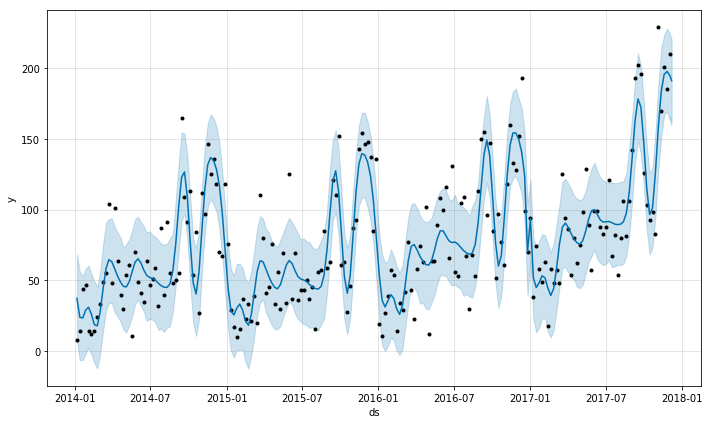

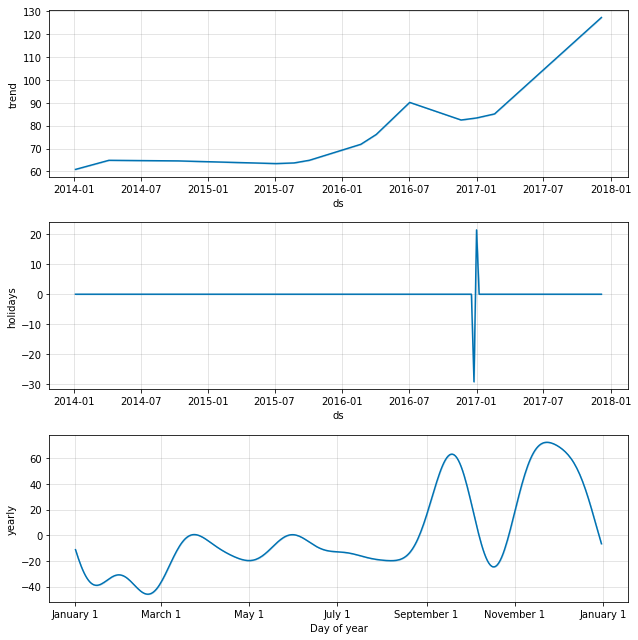

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Forecasting for cluster: 1
------------------------------------------------------------------------------------------------------------------------------------------------------


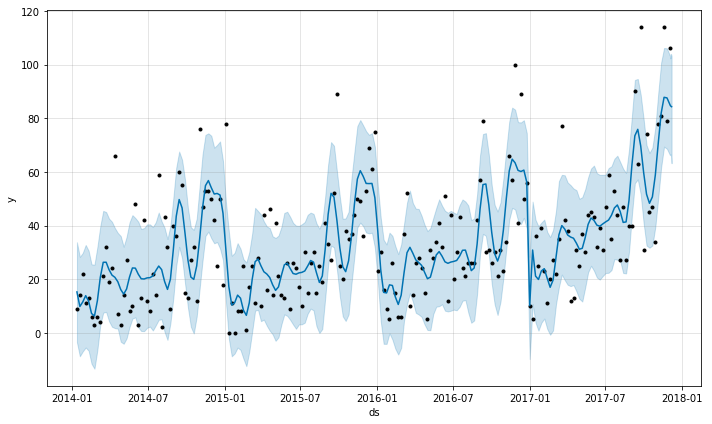

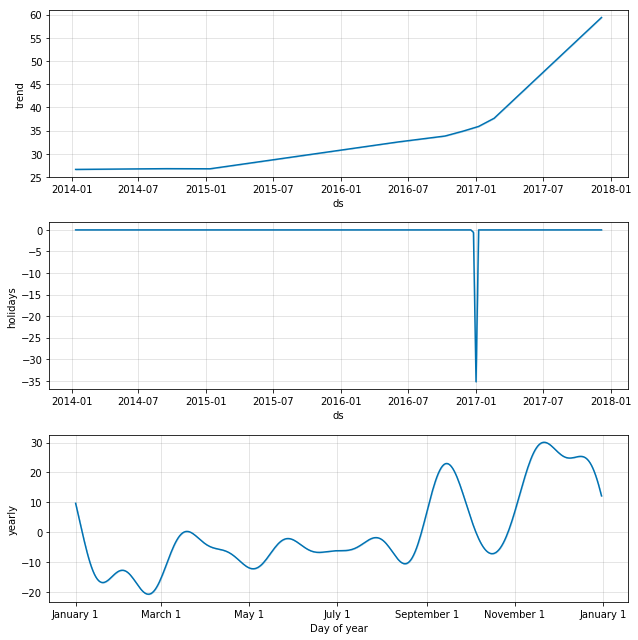

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Forecasting for cluster: 2
------------------------------------------------------------------------------------------------------------------------------------------------------


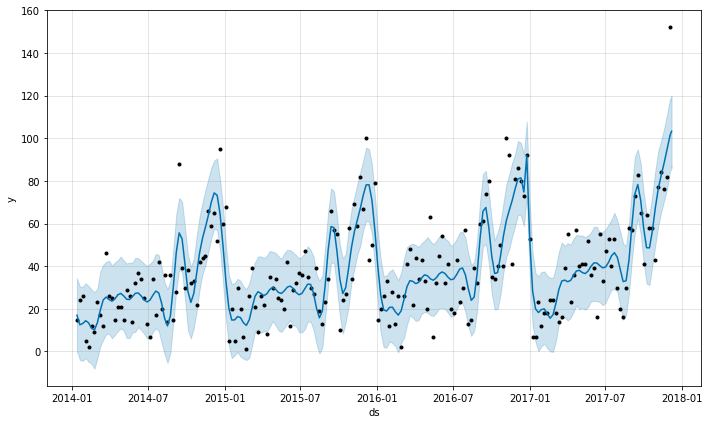

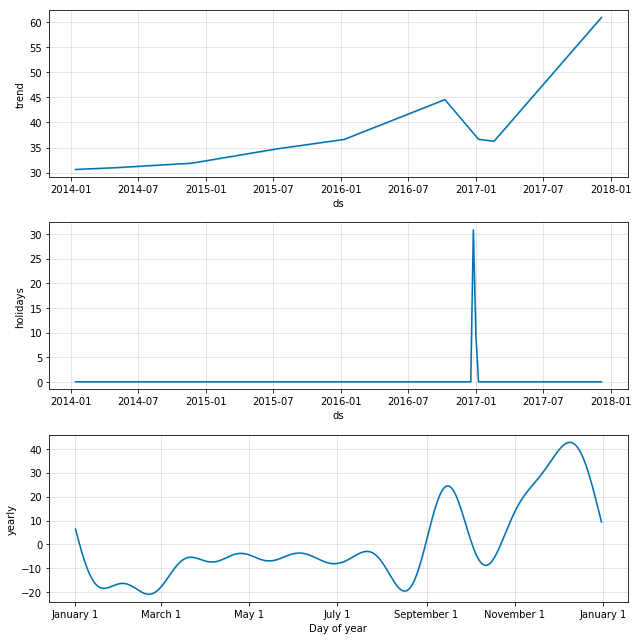

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Forecasting for cluster: 3
------------------------------------------------------------------------------------------------------------------------------------------------------


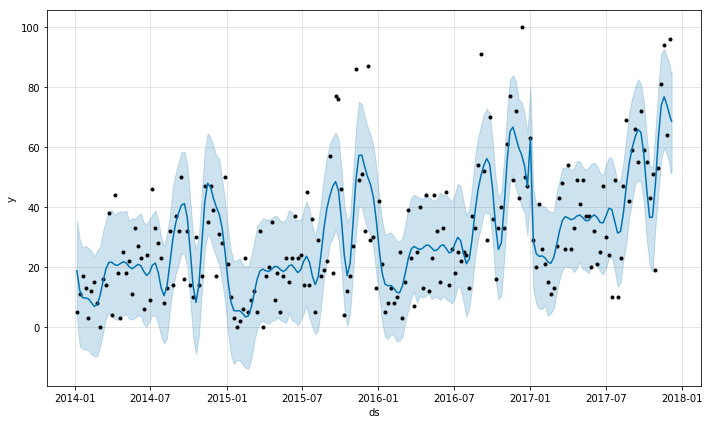

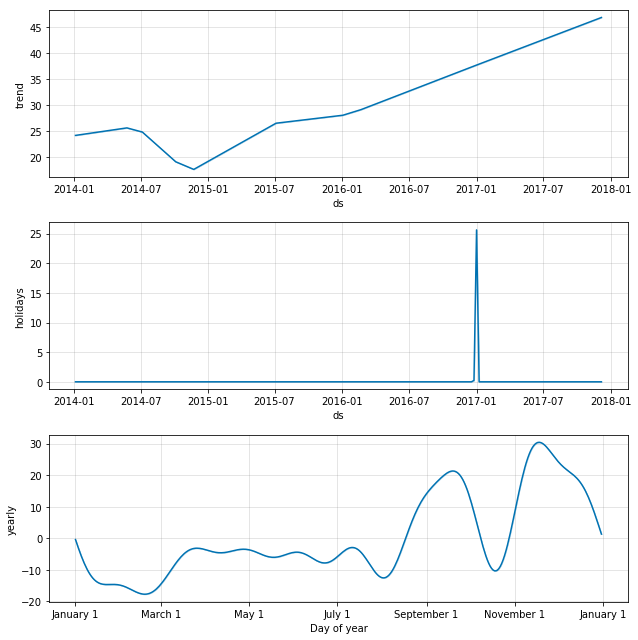

In [50]:
# Fitting fbprophet and plotting results in the weekly distribution for each cluster
forecasts = {}
models_weekly = {}
dict_predict_weekly = {}
for _, df in enumerate(df_ts_weekly):
    print(f'Forecasting for cluster: {_}')
    print('-'*150)
    df.reset_index(inplace=True)
    df.columns = ['ds','y']
    prediction_size = 4
    train_df = df[:-prediction_size]
    model = Prophet(changepoint_prior_scale=2, daily_seasonality=False)
    model.add_country_holidays(country_name='US')
    model.fit(train_df)
    future_dates = model.make_future_dataframe(periods=prediction_size,freq='D')
    forecast = model.predict(future_dates)
    m_predict_weekly = model.predict(df)
    model.plot(forecast,uncertainty=True)
    model.plot_components(forecast)
    forecasts['forecast' + str(_)] = forecast
    dict_predict_weekly['prd_weekly_' + str(_)] = m_predict_weekly
    models_weekly['ts' + str(_) + '_pkl_W'] = model
    plt.show()

In [51]:
models_weekly

{'ts0_pkl_W': <fbprophet.forecaster.Prophet at 0x7fcc17be66d8>,
 'ts1_pkl_W': <fbprophet.forecaster.Prophet at 0x7fcc17e43b00>,
 'ts2_pkl_W': <fbprophet.forecaster.Prophet at 0x7fcc17e774a8>,
 'ts3_pkl_W': <fbprophet.forecaster.Prophet at 0x7fcc17f07cf8>}

In [52]:
for name,model in models_weekly.items():
    pickle.dump(model, open(str(name) +".pkl","wb"),protocol=2)

In [53]:
# Fitting fbprophet and plotting results in the weekly distribution for each cluster
cmp_df0_weekly_ = make_comparison_dataframe(df_ts_0_weekly, forecasts['forecast0']).add_prefix('weekly_')
cmp_df1_weekly_ = make_comparison_dataframe(df_ts_1_weekly, forecasts['forecast1']).add_prefix('weekly_')
cmp_df2_weekly_ = make_comparison_dataframe(df_ts_2_weekly, forecasts['forecast2']).add_prefix('weekly_')
cmp_df3_weekly_ = make_comparison_dataframe(df_ts_3_weekly, forecasts['forecast3']).add_prefix('weekly_')

cmp_ls_weekly_ = [cmp_df0_weekly_,cmp_df1_weekly_,cmp_df2_weekly_,cmp_df3_weekly_]

In [54]:
# Comparison dataframe for weekly forecast for each cluster (entire dataframe predicted)
cmp_df0_weekly = make_comparison_dataframe(df_ts_0_weekly, dict_predict_weekly['prd_weekly_0']).add_prefix('weekly_')
cmp_df1_weekly = make_comparison_dataframe(df_ts_1_weekly, dict_predict_weekly['prd_weekly_1']).add_prefix('weekly_')
cmp_df2_weekly = make_comparison_dataframe(df_ts_2_weekly, dict_predict_weekly['prd_weekly_2']).add_prefix('weekly_')
cmp_df3_weekly = make_comparison_dataframe(df_ts_3_weekly, dict_predict_weekly['prd_weekly_3']).add_prefix('weekly_')

cmp_ls_weekly = [cmp_df0_weekly,cmp_df1_weekly,cmp_df2_weekly,cmp_df3_weekly]

In [55]:
# Printing errors
for _, cmp in enumerate(cmp_ls_weekly_):
    print('------------------------------')
    print(f'Errors for cluster {_}')
    for err_name, err_value in calculate_forecast_errors(cmp, prediction_size).items():
        print(err_name, err_value)

------------------------------
Errors for cluster 0
MAPE nan
MAE nan
------------------------------
Errors for cluster 1
MAPE nan
MAE nan
------------------------------
Errors for cluster 2
MAPE nan
MAE nan
------------------------------
Errors for cluster 3
MAPE nan
MAE nan


In [56]:
# resampling time series dataframes by month

df_ts_0_monthly = df_ts_all[df_ts_all['Cluster'] == 0][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('MS').sum()
df_ts_1_monthly = df_ts_all[df_ts_all['Cluster'] == 1][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('MS').sum()
df_ts_2_monthly = df_ts_all[df_ts_all['Cluster'] == 2][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('MS').sum()
df_ts_3_monthly = df_ts_all[df_ts_all['Cluster'] == 3][['Order_Date','Quantity']].groupby('Order_Date').sum().resample('MS').sum()

In [57]:
df_ts_monthly = [df_ts_0_monthly,df_ts_1_monthly,df_ts_2_monthly,df_ts_3_monthly]

Forecasting for cluster: 0
------------------------------------------------------------------------------------------------------------------------------------------------------


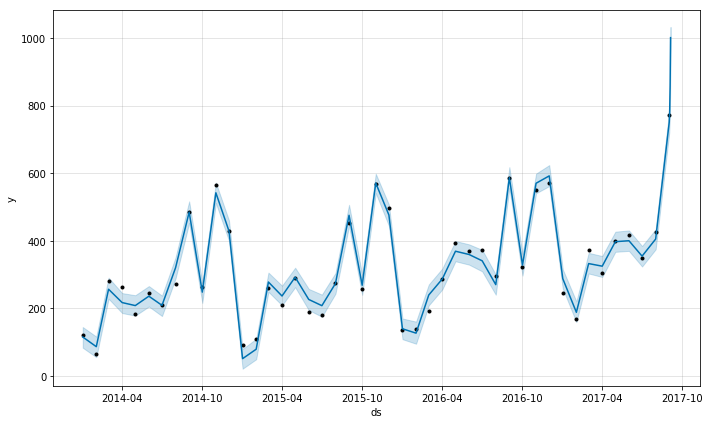

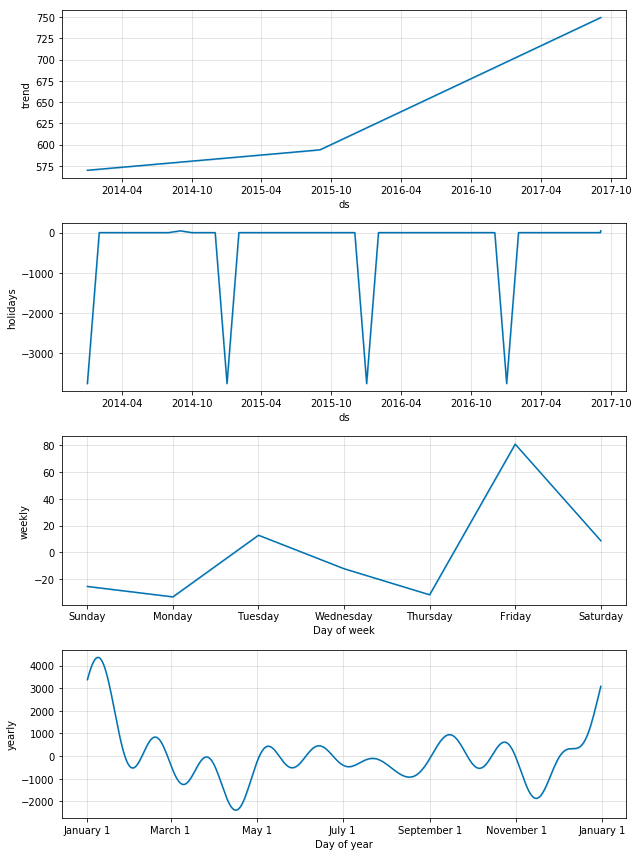

Forecasting for cluster: 1
------------------------------------------------------------------------------------------------------------------------------------------------------


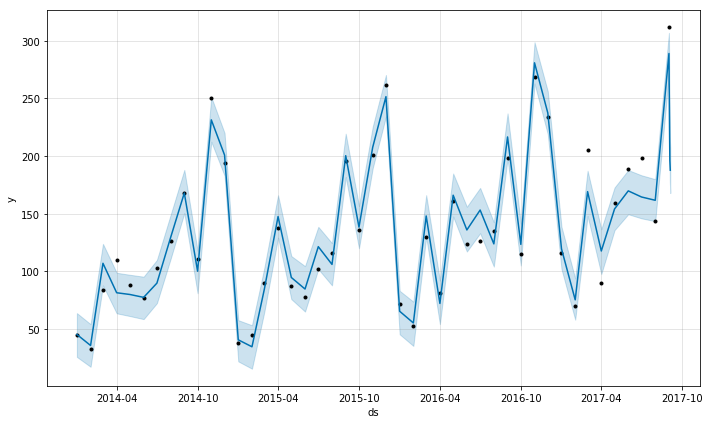

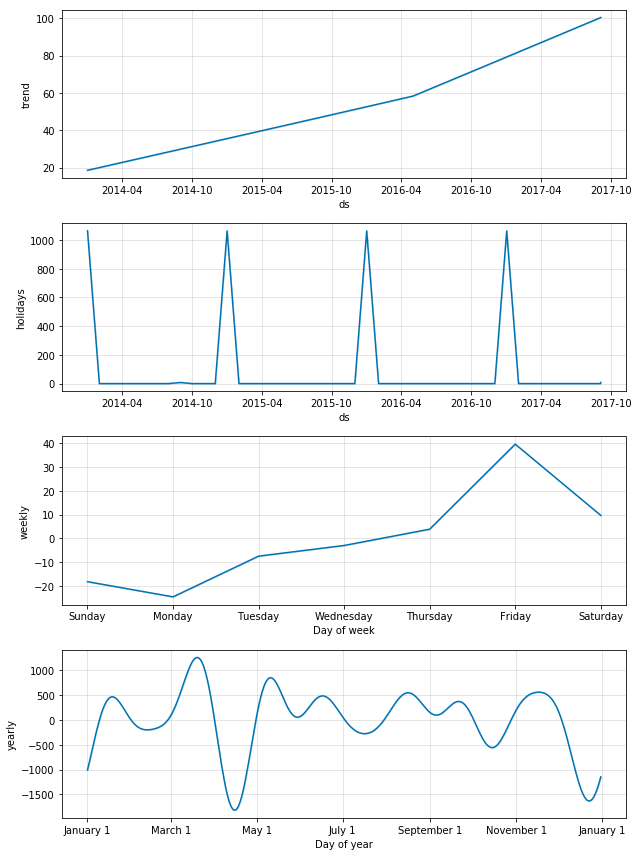

Forecasting for cluster: 2
------------------------------------------------------------------------------------------------------------------------------------------------------


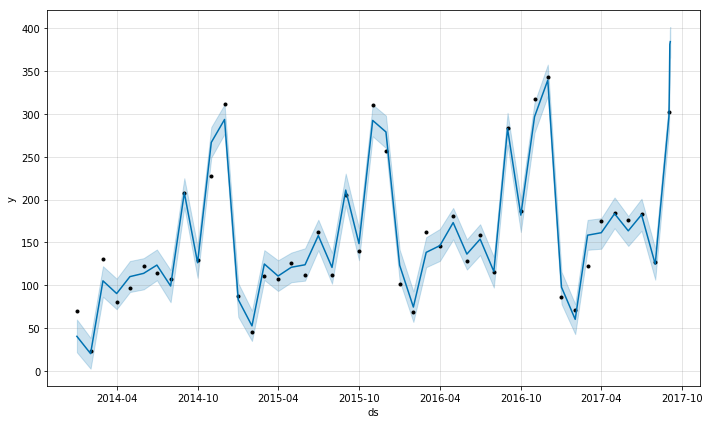

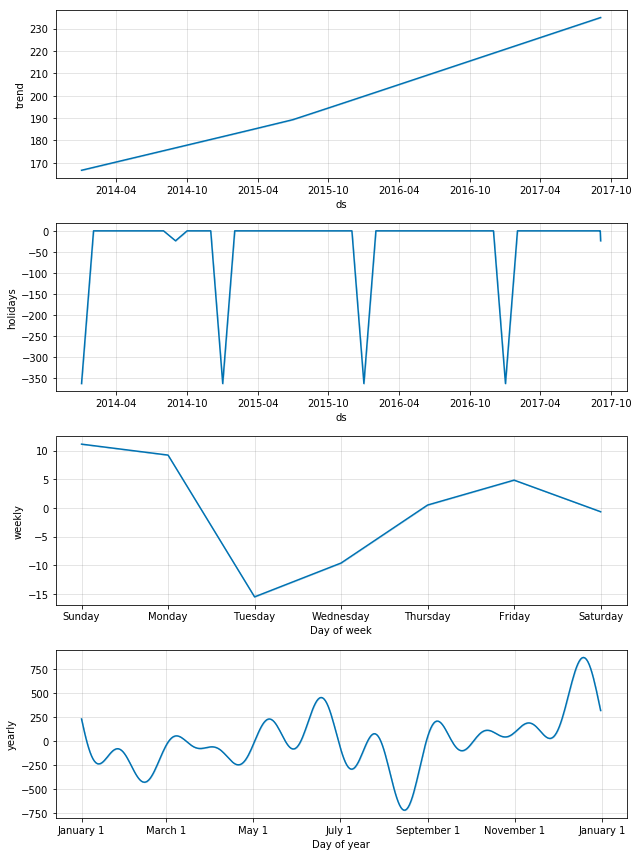

Forecasting for cluster: 3
------------------------------------------------------------------------------------------------------------------------------------------------------


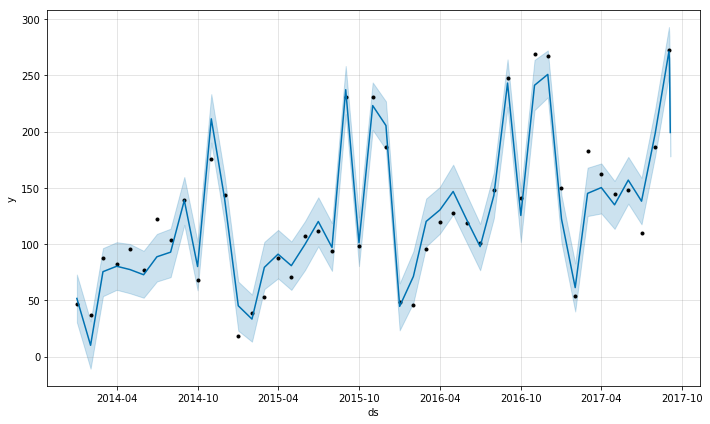

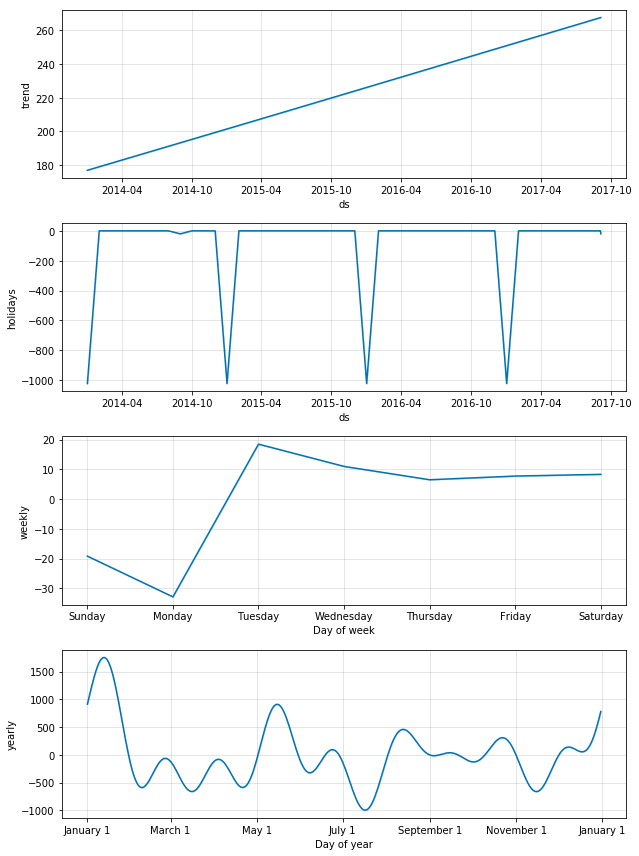

In [58]:
# Fitting fbprophet and plotting results in the monthly distribution for each cluster
forecasts = {}
models_monthly = {}
dict_predict_monthly = {}
for _, df in enumerate(df_ts_monthly):
    print(f'Forecasting for cluster: {_}')
    print('-'*150)
    df.reset_index(inplace=True)
    df.columns = ['ds','y']
    prediction_size = 3
    train_df = df[:-prediction_size]
    model = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False, weekly_seasonality=True)
    model.add_country_holidays(country_name='US')
    model.fit(train_df)
    future_dates = model.make_future_dataframe(periods=prediction_size,freq='D')
    forecast = model.predict(future_dates)
    m_predict_monthly = model.predict(df)
    model.plot(forecast,uncertainty=True)
    model.plot_components(forecast)
    dict_predict_monthly['prd_monthly_' + str(_)] = m_predict_monthly
    forecasts['forecast' + str(_)] = forecast
    models_monthly['ts' + str(_) + '_pkl_M'] = model
    plt.show()

In [59]:
for name,model in models_monthly.items():
    pickle.dump(model, open(str(name) +".pkl","wb"),protocol=2)

In [60]:
# Comparison dataframe for daily forecast for each cluster (appending forecasting with train test dataframes)
cmp_df0_monthly_ = make_comparison_dataframe(df_ts_0_monthly, forecasts['forecast0']).add_prefix('monthly_')
cmp_df1_monthly_ = make_comparison_dataframe(df_ts_1_monthly, forecasts['forecast1']).add_prefix('monthly_')
cmp_df2_monthly_ = make_comparison_dataframe(df_ts_2_monthly, forecasts['forecast2']).add_prefix('monthly_')
cmp_df3_monthly_ = make_comparison_dataframe(df_ts_3_monthly, forecasts['forecast3']).add_prefix('monthly_')

cmp_ls_monthly_ = [cmp_df0_monthly_,cmp_df1_monthly_,cmp_df2_monthly_,cmp_df3_monthly_]

In [61]:
# Comparison dataframe for daily forecast for each cluster (entire dataframe predicted)
cmp_df0_monthly = make_comparison_dataframe(df_ts_0_monthly, dict_predict_monthly['prd_monthly_0']).add_prefix('monthly_')
cmp_df1_monthly = make_comparison_dataframe(df_ts_1_monthly, dict_predict_monthly['prd_monthly_1']).add_prefix('monthly_')
cmp_df2_monthly = make_comparison_dataframe(df_ts_2_monthly, dict_predict_monthly['prd_monthly_2']).add_prefix('monthly_')
cmp_df3_monthly = make_comparison_dataframe(df_ts_3_monthly, dict_predict_monthly['prd_monthly_3']).add_prefix('monthly_')

cmp_ls_monthly = [cmp_df0_monthly,cmp_df1_monthly,cmp_df2_monthly,cmp_df3_monthly]

In [62]:
# Printing errors
for _, cmp in enumerate(cmp_ls_monthly_):
    print('------------------------------')
    print(f'Errors for cluster {_}')
    for err_name, err_value in calculate_forecast_errors(cmp, prediction_size).items():
        print(err_name, err_value)

------------------------------
Errors for cluster 0
MAPE nan
MAE nan
------------------------------
Errors for cluster 1
MAPE nan
MAE nan
------------------------------
Errors for cluster 2
MAPE nan
MAE nan
------------------------------
Errors for cluster 3
MAPE nan
MAE nan


In [63]:
# Creating timestamp features in the comparation dataframe
for df in cmp_ls_daily:
    df.reset_index(inplace=True)
    df['day'] = df['ds'].apply(lambda x: x.day)
    df['week'] = df['ds'].apply(lambda x: x.week)
    df['month'] = df['ds'].apply(lambda x: x.month)
    df['year'] = df['ds'].apply(lambda x: x.year)
    
for df in cmp_ls_weekly:
    df.reset_index(inplace=True)
    df['day'] = df['ds'].apply(lambda x: x.day)
    df['week'] = df['ds'].apply(lambda x: x.week)
    df['month'] = df['ds'].apply(lambda x: x.month)
    df['year'] = df['ds'].apply(lambda x: x.year)

for df in cmp_ls_monthly:
    df.reset_index(inplace=True)
    df['day'] = df['ds'].apply(lambda x: x.day)
    df['week'] = df['ds'].apply(lambda x: x.week)
    df['month'] = df['ds'].apply(lambda x: x.month)
    df['year'] = df['ds'].apply(lambda x: x.year)


In [64]:
df0 = df_ts_all[df_ts_all['Cluster'] == 0].groupby(['Order_Date','Product_ID']).sum().reset_index()
df1 = df_ts_all[df_ts_all['Cluster'] == 1].groupby(['Order_Date','Product_ID']).sum().reset_index()
df2 = df_ts_all[df_ts_all['Cluster'] == 2].groupby(['Order_Date','Product_ID']).sum().reset_index()
df3 = df_ts_all[df_ts_all['Cluster'] == 3].groupby(['Order_Date','Product_ID']).sum().reset_index()

df_base = [df0,df1,df2,df3]



In [65]:
# Creating timestamp features 
for df in df_base:
    df['week_day'] = df['Order_Date'].apply(lambda x: x.weekday())
    df['day']      = df['Order_Date'].apply(lambda x: x.day)
    df['week']     = df['Order_Date'].apply(lambda x: x.week)
    df['month']    = df['Order_Date'].apply(lambda x: x.month)
    df['year']     = df['Order_Date'].apply(lambda x: x.year)


In [66]:
# Creating dict for daily percentage of sales of each product and cluster

dict_daily = {}
for _, df in enumerate(df_base):
    df_ = df.copy()
    df_ = df_.merge(df_[['Order_Date','Product_ID','Quantity']].groupby('Order_Date').sum().reset_index(),how='left',on='Order_Date')
    df_['Quantity_daily'] = df_['Quantity_y']
    df_['Quantity'] = df_['Quantity_x']
    df_.drop(['Quantity_y','Quantity_x'],axis=1,inplace=True)
    df_['Perc_Qtd_Daily'] = df_['Quantity']/df_['Quantity_daily']
    df_ = df_[['Product_ID','day','week','month','year','Perc_Qtd_Daily']]
    dict_daily['Daily_' + str(_)] = df_

In [67]:
# Creating dict for weekly percentage of sales of each product and cluster

dict_weekly = {}
for _,df in enumerate(df_base):
    df_ = df.copy()
    df_  = df_.merge(df_[['Product_ID','year','month','week','Quantity']].groupby(['year','month','week']).sum().reset_index(),how='left',on=['year','month','week'])
    df_['Quantity_Weekly'] = df_['Quantity_y']
    df_['Quantity'] = df_['Quantity_x']
    df_.drop(['Quantity_y','Quantity_x'],axis=1,inplace=True)
    df_['Perc_Qtd_Weekly'] = df_['Quantity']/df_['Quantity_Weekly']
    df_ = df_[['Product_ID','week','month','year','Perc_Qtd_Weekly']]
    dict_weekly['Weekly_' + str(_)] = df_


In [68]:
# Creating dict for monthly percentage of sales of each product and cluster

dict_monthly = {}
for _,df in enumerate(df_base):
    df_ = df.copy()
    df_  = df_.merge(df_[['Product_ID','year','month','Quantity']].groupby(['year','month']).sum().reset_index(),how='left',on=['year','month'])
    df_['Quantity_Monthly'] = df_['Quantity_y']
    df_['Quantity'] = df_['Quantity_x']
    df_.drop(['Quantity_y','Quantity_x'],axis=1,inplace=True)
    df_['Perc_Qtd_Monthly'] = df_['Quantity']/df_['Quantity_Monthly']
    df_ = df_[['Product_ID','month','year','Perc_Qtd_Monthly']]
    dict_monthly['Monthly_' + str(_)] = df_


In [69]:
# Merging daily, weekly and monthly percentages

dim_perc = {}
for i in range(0,4):
    dim_perc['df_dim_perc_' + str(i)] = dict_daily['Daily_'+str(i)].merge(dict_weekly['Weekly_'+str(i)].merge(dict_monthly['Monthly_'+str(i)],
                                                                                                              how='left',on=['Product_ID','month','year'])
                                                                          ,how='left',on=['Product_ID', 'week', 'month','year'])

In [70]:
df_dim_perc_0 = pd.DataFrame(dim_perc['df_dim_perc_0'])
df_dim_perc_1 = pd.DataFrame(dim_perc['df_dim_perc_1'])
df_dim_perc_2 = pd.DataFrame(dim_perc['df_dim_perc_2'])
df_dim_perc_3 = pd.DataFrame(dim_perc['df_dim_perc_3'])

In [71]:
df_dim_perc_0.head()

Product_ID  day  week  month  year  Perc_Qtd_Daily  Perc_Qtd_Weekly  \
0  OFF-PA-10000174    3     1      1  2014        1.000000         0.250000   
1  OFF-LA-10003223    4     1      1  2014        1.000000         0.375000   
2  OFF-AR-10003478    5     1      1  2014        1.000000         0.375000   
3  OFF-AR-10001662    6     2      1  2014        0.153846         0.142857   
4  OFF-AR-10002399    6     2      1  2014        0.230769         0.214286   

   Perc_Qtd_Monthly  
0          0.016393  
1          0.024590  
2          0.024590  
3          0.016393  
4          0.024590

In [72]:
# Setting mean percentage of sales for each cluster

df_dim_perc_0 = df_dim_perc_0[['Product_ID','Perc_Qtd_Daily','Perc_Qtd_Weekly','Perc_Qtd_Monthly']].groupby('Product_ID').mean().reset_index()
df_dim_perc_1 = df_dim_perc_1[['Product_ID','Perc_Qtd_Daily','Perc_Qtd_Weekly','Perc_Qtd_Monthly']].groupby('Product_ID').mean().reset_index()
df_dim_perc_2 = df_dim_perc_2[['Product_ID','Perc_Qtd_Daily','Perc_Qtd_Weekly','Perc_Qtd_Monthly']].groupby('Product_ID').mean().reset_index()
df_dim_perc_3 = df_dim_perc_3[['Product_ID','Perc_Qtd_Daily','Perc_Qtd_Weekly','Perc_Qtd_Monthly']].groupby('Product_ID').mean().reset_index()


In [73]:
# Exporting to csv

df_dim_perc_0.to_csv('./cluster0_share.csv')
df_dim_perc_1.to_csv('./cluster1_share.csv')
df_dim_perc_2.to_csv('./cluster2_share.csv')
df_dim_perc_3.to_csv('./cluster3_share.csv')

In [74]:
# Creating dataframe for ensemble, all predictions from time series (daily,weekly, monthly) and multiplying for corresponding percentage value for each product (cluster 0)

df_ens_0 = cmp_df0_daily.drop(['ds','daily_y'],axis=1).merge(cmp_df0_weekly.drop(['ds','day','weekly_y'],axis=1),
                                                             how='left',on=['week','month','year']).merge(cmp_df0_monthly.drop(['ds','day','week','monthly_y'],axis=1),how='left',on=['month','year'])

df_ens_0['key'] = 0
df_dim_perc_0['key'] = 0
df_ens_0 = df_ens_0.merge(df_dim_perc_0,how='left',on='key').drop('key',axis=1)
df_ens_0['daily_yhat'] = df_ens_0['daily_yhat']*df_ens_0['Perc_Qtd_Daily']
df_ens_0['daily_yhat_lower'] = df_ens_0['daily_yhat_lower']*df_ens_0['Perc_Qtd_Daily'] 
df_ens_0['daily_yhat_upper'] = df_ens_0['daily_yhat_upper']*df_ens_0['Perc_Qtd_Daily'] 
df_ens_0['weekly_yhat'] = df_ens_0['weekly_yhat']*df_ens_0['Perc_Qtd_Weekly']
df_ens_0['weekly_yhat_lower'] = df_ens_0['weekly_yhat_lower']*df_ens_0['Perc_Qtd_Weekly'] 
df_ens_0['weekly_yhat_upper'] = df_ens_0['weekly_yhat_upper']*df_ens_0['Perc_Qtd_Weekly'] 
df_ens_0['monthly_yhat'] = df_ens_0['monthly_yhat']*df_ens_0['Perc_Qtd_Monthly']
df_ens_0['monthly_yhat_lower'] = df_ens_0['monthly_yhat_lower']*df_ens_0['Perc_Qtd_Monthly'] 
df_ens_0['monthly_yhat_upper'] = df_ens_0['monthly_yhat_upper']*df_ens_0['Perc_Qtd_Monthly'] 
df_ens_0 = df_ens_0.merge(df0.drop(['Order_Date','Cluster','week_day'],axis=1),how='left', on = ['Product_ID','day','week','month','year']).dropna(subset=['Quantity'])

In [75]:
# Creating dataframe for ensemble, all predictions from time series (daily,weekly, monthly) and multiplying for corresponding percentage value for each product (cluster 1)


df_ens_1 = cmp_df1_daily.drop(['ds','daily_y'],axis=1).merge(cmp_df1_weekly.drop(['ds','day','weekly_y'],axis=1),
                                                             how='left',on=['week','month','year']).merge(cmp_df1_monthly.drop(['ds','day','week','monthly_y'],axis=1),how='left',on=['month','year'])

df_ens_1['key'] = 1
df_dim_perc_1['key'] = 1
df_ens_1 = df_ens_1.merge(df_dim_perc_1,how='left',on='key').drop('key',axis=1)
df_ens_1['daily_yhat'] = df_ens_1['daily_yhat']*df_ens_1['Perc_Qtd_Daily']
df_ens_1['daily_yhat_lower'] = df_ens_1['daily_yhat_lower']*df_ens_1['Perc_Qtd_Daily'] 
df_ens_1['daily_yhat_upper'] = df_ens_1['daily_yhat_upper']*df_ens_1['Perc_Qtd_Daily'] 
df_ens_1['weekly_yhat'] = df_ens_1['weekly_yhat']*df_ens_1['Perc_Qtd_Weekly']
df_ens_1['weekly_yhat_lower'] = df_ens_1['weekly_yhat_lower']*df_ens_1['Perc_Qtd_Weekly'] 
df_ens_1['weekly_yhat_upper'] = df_ens_1['weekly_yhat_upper']*df_ens_1['Perc_Qtd_Weekly'] 
df_ens_1['monthly_yhat'] = df_ens_1['monthly_yhat']*df_ens_1['Perc_Qtd_Monthly']
df_ens_1['monthly_yhat_lower'] = df_ens_1['monthly_yhat_lower']*df_ens_1['Perc_Qtd_Monthly'] 
df_ens_1['monthly_yhat_upper'] = df_ens_1['monthly_yhat_upper']*df_ens_1['Perc_Qtd_Monthly'] 
df_ens_1 = df_ens_1.merge(df1.drop(['Order_Date','Cluster','week_day'],axis=1),how='left', on = ['Product_ID','day','week','month','year']).dropna(subset=['Quantity'])

In [76]:
# Creating dataframe for ensemble, all predictions from time series (daily,weekly, monthly) and multiplying for corresponding percentage value for each product (cluster 2)


df_ens_2 = cmp_df2_daily.drop(['ds','daily_y'],axis=1).merge(cmp_df2_weekly.drop(['ds','day','weekly_y'],axis=1),
                                                             how='left',on=['week','month','year']).merge(cmp_df2_monthly.drop(['ds','day','week','monthly_y'],axis=1),how='left',on=['month','year'])

df_ens_2['key'] = 2
df_dim_perc_2['key'] = 2
df_ens_2 = df_ens_2.merge(df_dim_perc_2,how='left',on='key').drop('key',axis=1)
df_ens_2['daily_yhat'] = df_ens_2['daily_yhat']*df_ens_2['Perc_Qtd_Daily']
df_ens_2['daily_yhat_lower'] = df_ens_2['daily_yhat_lower']*df_ens_2['Perc_Qtd_Daily'] 
df_ens_2['daily_yhat_upper'] = df_ens_2['daily_yhat_upper']*df_ens_2['Perc_Qtd_Daily'] 
df_ens_2['weekly_yhat'] = df_ens_2['weekly_yhat']*df_ens_2['Perc_Qtd_Weekly']
df_ens_2['weekly_yhat_lower'] = df_ens_2['weekly_yhat_lower']*df_ens_2['Perc_Qtd_Weekly'] 
df_ens_2['weekly_yhat_upper'] = df_ens_2['weekly_yhat_upper']*df_ens_2['Perc_Qtd_Weekly'] 
df_ens_2['monthly_yhat'] = df_ens_2['monthly_yhat']*df_ens_2['Perc_Qtd_Monthly']
df_ens_2['monthly_yhat_lower'] = df_ens_2['monthly_yhat_lower']*df_ens_2['Perc_Qtd_Monthly'] 
df_ens_2['monthly_yhat_upper'] = df_ens_2['monthly_yhat_upper']*df_ens_2['Perc_Qtd_Monthly'] 
df_ens_2 = df_ens_2.merge(df2.drop(['Order_Date','Cluster','week_day'],axis=1),how='left', on = ['Product_ID','day','week','month','year']).dropna(subset=['Quantity'])

In [77]:
# Creating dataframe for ensemble, all predictions from time series (daily,weekly, monthly) and multiplying for corresponding percentage value for each product (cluster 3)


df_ens_3 = cmp_df3_daily.drop(['ds','daily_y'],axis=1).merge(cmp_df3_weekly.drop(['ds','day','weekly_y'],axis=1),
                                                             how='left',on=['week','month','year']).merge(cmp_df3_monthly.drop(['ds','day','week','monthly_y'],axis=1),how='left',on=['month','year'])

df_ens_3['key'] = 3
df_dim_perc_3['key'] = 3
df_ens_3 = df_ens_3.merge(df_dim_perc_3,how='left',on='key').drop('key',axis=1)
df_ens_3['daily_yhat'] = df_ens_3['daily_yhat']*df_ens_3['Perc_Qtd_Daily']
df_ens_3['daily_yhat_lower'] = df_ens_3['daily_yhat_lower']*df_ens_3['Perc_Qtd_Daily'] 
df_ens_3['daily_yhat_upper'] = df_ens_3['daily_yhat_upper']*df_ens_3['Perc_Qtd_Daily'] 
df_ens_3['weekly_yhat'] = df_ens_3['weekly_yhat']*df_ens_3['Perc_Qtd_Weekly']
df_ens_3['weekly_yhat_lower'] = df_ens_3['weekly_yhat_lower']*df_ens_3['Perc_Qtd_Weekly'] 
df_ens_3['weekly_yhat_upper'] = df_ens_3['weekly_yhat_upper']*df_ens_3['Perc_Qtd_Weekly'] 
df_ens_3['monthly_yhat'] = df_ens_3['monthly_yhat']*df_ens_3['Perc_Qtd_Monthly']
df_ens_3['monthly_yhat_lower'] = df_ens_3['monthly_yhat_lower']*df_ens_3['Perc_Qtd_Monthly'] 
df_ens_3['monthly_yhat_upper'] = df_ens_3['monthly_yhat_upper']*df_ens_3['Perc_Qtd_Monthly'] 
df_ens_3 = df_ens_3.merge(df3.drop(['Order_Date','Cluster','week_day'],axis=1),how='left', on = ['Product_ID','day','week','month','year']).dropna(subset=['Quantity'])

In [78]:
df_ens_0.head(10)

daily_yhat  daily_yhat_lower  daily_yhat_upper  day  week  month  year  \
438     2.464061         -1.752716          6.527839    3     1      1  2014   
1262    3.591935         -2.901089          9.883968    4     1      1  2014   
1933    3.944139         -4.352539         12.128876    5     1      1  2014   
2739    1.288816         -1.000790          3.655926    6     2      1  2014   
2766    2.331076         -1.810125          6.612460    6     2      1  2014   
2923    3.466512         -2.691812          9.833300    6     2      1  2014   
3080    0.623938         -0.484499          1.769896    6     2      1  2014   
3149    1.371064         -1.064657          3.889236    6     2      1  2014   
3866    4.792841         -3.799026         14.239031   10     2      1  2014   
4525    1.649887         -1.221960          4.577532   13     3      1  2014   

      weekly_yhat  weekly_yhat_lower  weekly_yhat_upper  monthly_yhat  \
438      3.839700           0.715412           6.892441      1.694409   
1262     4.420181           0.823568           7.934432      2.080491   
1933     5.321884           0.991573           9.553032      2.260099   
2739     1.366117          -0.367041           3.040540      1.142496   
2766     2.941323          -0.790259           6.546443      2.065878   
2923     4.106329          -1.103267           9.139373      3.192012   
3080     0.926708          -0.248983           2.062555      0.730886   
3149     1.566390          -0.420849           3.486282      1.179645   
3866     1.391989          -0.373992           3.098122      0.970958   
4525     2.189879          -0.395076           4.952395      2.402058   

      monthly_yhat_lower  monthly_yhat_upper       Product_ID  Perc_Qtd_Daily  \
438             1.247794            2.151842  OFF-PA-10000174        0.313022   
1262            1.532112            2.642153  OFF-LA-10003223        0.473128   
1933            1.664379            2.870249  OFF-AR-10003478        0.591952   
2739            0.841355            1.450932  OFF-AR-10001662        0.171000   
2766            1.521351            2.623596  OFF-AR-10002399        0.309287   
2923            2.350657            4.053748  OFF-FA-10001883        0.459936   
3080            0.538238            0.928201  OFF-PA-10000955        0.082784   
3149            0.868712            1.498109  OFF-PA-10002005        0.181912   
3866            0.715031            1.233084  OFF-LA-10004272        0.625000   
4525            1.768920            3.050533  OFF-AR-10003514        0.215513   

      Perc_Qtd_Weekly  Perc_Qtd_Monthly  Quantity  
438          0.102949          0.014652       2.0  
1262         0.118513          0.017991       3.0  
1933         0.142689          0.019544       3.0  
2739         0.057022          0.009880       2.0  
2766         0.122772          0.017865       3.0  
2923         0.171400          0.027603       4.0  
3080         0.038681          0.006320       1.0  
3149         0.065382          0.010201       3.0  
3866         0.058102          0.008396       1.0  
4525         0.093263          0.020772       5.0

In [79]:
df_ens = [df_ens_0,df_ens_1,df_ens_2,df_ens_3]

In [80]:
# Changing variable name to target instead of quantity
for _, df in enumerate(df_ens):
    df['target'] = df['Quantity']
    df.drop('Quantity', axis= 1,inplace=True)

In [81]:
# Creating a dict for train test split for each cluster

train_test_dict = {}
for _, df in enumerate(df_ens):
    df.rename({'Quantity':'target'},inplace=True)
    y = df['target']
    X = df.drop(['target'],axis=1).set_index('Product_ID')
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    train_test_dict['X' + str(_)] = X.fillna(0)
    train_test_dict['y' + str(_)] = y
    train_test_dict['X_train' + str(_)] = X_train.fillna(0)
    train_test_dict['X_test' + str(_)] = X_test.fillna(0)
    train_test_dict['y_train' + str(_)] = y_train
    train_test_dict['y_test' + str(_)] = y_test


In [82]:
# Fitting a grid seach for each cluster

dict_grid_results = {}
dict_best_params = {}
for i in range(0,4):
    gsc = GridSearchCV(estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(train_test_dict['X'+str(i)].fillna(0), train_test_dict['y'+str(i)])
    dict_grid_results['ensemble' + str(i) + '_pkl'] = grid_result
    dict_best_params['grid_params_' +str(i)] = grid_result.best_params_

In [83]:
y_pred0 = dict_grid_results['ensemble0_pkl'].predict(train_test_dict['X_test0'])
y_pred1 = dict_grid_results['ensemble1_pkl'].predict(train_test_dict['X_test1'])
y_pred2 = dict_grid_results['ensemble2_pkl'].predict(train_test_dict['X_test2'])
y_pred3 = dict_grid_results['ensemble3_pkl'].predict(train_test_dict['X_test3'])

In [84]:
for name,model in dict_grid_results.items():
    pickle.dump(model, open(str(name) +".pkl","wb"))

MAE metrics for each cluster:

In [85]:
metrics.mean_absolute_error(train_test_dict['y_test0'],y_pred0)

1.594510430772565

In [86]:
metrics.mean_absolute_error(train_test_dict['y_test1'],y_pred1)

1.6376954066575173

In [87]:
metrics.mean_absolute_error(train_test_dict['y_test2'],y_pred2)

1.6598592929252995

In [88]:
metrics.mean_absolute_error(train_test_dict['y_test3'],y_pred3)

1.6776194414945131